In [2]:
import numpy as np
import h5py
from scipy.signal import find_peaks
from os import listdir
from tqdm import tqdm

class Comsol_data_analysis:

    def __init__(self, filename, path):
        self.filename = filename
        self.path = path
        self.file = h5py.File(self.path + self.filename, 'r')
        
        # x range data
        self._handle_x()

        # explore shape and variables
        _keys_list = list(self.file.keys())
        self.path_list = [[item for item in _keys_list if item != 'positions']]
        self.shape = [len(self.path_list[0])]
        self.variables = [] # initialiye variables 
        self._get_variables_dictionary(self.path_list[0]) # first step

        _sample_path = self.path_list[0][0] # initialize exploration
        _not_leaf = True
        while _not_leaf:
            try:
                _keys_list = self._get_sorted_keys_list(_sample_path)
                self.path_list.append(_keys_list)
                self.shape.append(len(_keys_list)) # 
                self._get_variables_dictionary(_keys_list) # update self.variables
                
                _sample_path += '/' + _keys_list[0]
            except:
                _not_leaf = False
        self.shape = tuple(self.shape)
    
    def analyse(self, func, outsize=1, outtype=float):
        # func is assumed to be a function of u(x)

        _shape = list(self.shape)
        if outsize > 1: _shape += [outsize]
        
        array = np.empty(_shape, dtype=outtype)

        # Define a recursive function to fill the array
        def _recursive_fill(array, func_inner, indices):
            if len(indices) == len(self.shape):
                array[tuple(indices)] = func_inner(self._index2u(indices))
            else:
                for i in range(_shape[len(indices)]):
                    _recursive_fill(array, func_inner, indices + [i])

        # Start filling the array
        _recursive_fill(array, func, [])
        return array
        
    def print(self):
        for d in self.variables:
            if type(list(d.values())[0]) == type(None):
                print(list(d.keys()))
            else:
                print(list(d.keys())[0] + f' = {list(d.values())[0][0]}, ..., {list(d.values())[0][-1]}    ({len(list(d.values())[0])} values)')
        
        print(f'x = {self.xmin}, ..., {self.xmax} ({self.nx} values),   dx = {self.dx}')
    
    def _sort_stringfloats(self, list_of_floatstrings):
        # input: ['a=1', 'a=0']
        # output: [0.0, 1.0], ['a=0', 'a=1']

        arr = np.zeros(len(list_of_floatstrings))
        name = list_of_floatstrings[0].split("=")[0]

        for i,key in enumerate(list_of_floatstrings):
            key_split = key.split("=")
            assert key_split[0] == name
            arr[i] = float(key_split[1])

        sort_inds = np.argsort(arr)
        return arr[sort_inds], list(np.array(list_of_floatstrings)[sort_inds])


    def _is_numeric(self, keys_list):
        sample_key = keys_list[0]
        sample_key_split = sample_key.split("=")
        if len(sample_key_split) > 1:
            return True
        else:
            return False

    def _get_variables_dictionary(self, keys_list):
        dic = {}
        if self._is_numeric(keys_list):
            arr, _ = self._sort_stringfloats(keys_list)
            name = keys_list[0].split("=")[0]
            if name == 't': self._handle_time(arr)
            dic[name] = arr
        else:
            for key in keys_list:
                dic[key] = None
            
        self.variables.append(dic)

    def _handle_x(self):
        self.x_range = np.array(self.file['positions/X'])
        self.xmin = self.x_range[0]
        self.xmax = self.x_range[-1]
        self.dx = self.x_range[1]-self.x_range[0]
        self.nx = len(self.x_range)

    def _handle_time(self, arr):
        self.t_range = arr
        self.tmin = arr[0]
        self.tmax = arr[-1]
        self.dt = self.t_range[1]-self.t_range[0]
        self.nt = len(arr)

    def _get_sorted_keys_list(self, _sample_path):
        ini_list = list(self.file[_sample_path].keys())
        if self._is_numeric(ini_list):
            _, new_list = self._sort_stringfloats(ini_list)
            return new_list
        else:
            return ini_list

    def _index2path(self, indicies):
        _path_string = ''
        for i,ind in enumerate(indicies):
            _path_string += self.path_list[i][ind] + '/'
        return _path_string[:-1] # not the last /

    def _index2u(self, indicies):
        return np.array(self.file[self._index2path(indicies)])

def find_half_peaks(signal, **kwargs):
    peaks, peaks_info = find_peaks(signal, **kwargs)
    half_peaks, half_peaks_info = find_peaks(np.convolve(signal, np.ones(5)/5., mode='same'), **kwargs)
    if len(peaks) == len(half_peaks):
        return peaks, peaks_info
    elif len(peaks) == len(half_peaks) - 2:
        return np.array([0] + list(peaks) + [len(signal)-1]), half_peaks_info
    elif len(peaks) == len(half_peaks) - 1:
        if half_peaks[0] <= 5:
            return np.array([0] + list(peaks)), half_peaks_info
        elif half_peaks[-1] >= len(half_peaks) - 5:
            return np.array(list(peaks) + [len(signal)-1]), half_peaks_info
        else:
            raise(IndexError)
    else:
        # probably convolve killed some peaks (random begining), so just ignore this
        return peaks, peaks_info

def lin_grad(array, axis=0):
    if axis==0:
        return array[1:] - array[:-1]
    elif axis==1:
        return array[:, 1:] - array[:, :-1]
    elif axis==2:
        return array[:, :, 1:] - array[:, :, :-1]
    else:
        1/0

            

In [3]:
# h5 file(s) location
path_to_h5_files = "/scratch/n/Natan.Dominko/h5_data/"
# path_to_h5_files = "/home/n/Natan.Dominko/Downloads/"
# list all files in folder
filenames = [f for f in listdir(path_to_h5_files) if (f[-3:] == ".h5")]
print(f"Files in current directory: {filenames}")

Files in current directory: ['logistic_t_1e5_L_sweep_16.h5', 'logistic_t_1e5_eps_1e1_1.h5', 'logistic_t_1e5_L_sweep_17.h5', 'logistic_t_5e5_eps_1e2_1.h5', 'logistic_t_1e5_L_sweep_15.h5', 'logistic_t_8e5_eps_1e1.h5', 'logistic_t_1e5_L_sweep_14.h5', 'logistic_t_1e5_L_sweep_10.h5', 'logistic_t_5e5_eps_1e2.h5', 'logistic_t_1_5e5_eps_1e1.h5', 'logistic_t_1e5_eps_1e1.h5', 'logistic_t_1e5_L_sweep_11.h5', 'logistic_t_1e5_L_sweep_9.h5', 'logistic_t_1e5_L_sweep_13.h5', 'logistic_t_1e5_eps_1e2.h5', 'logistic_t_1e5_L_sweep_12.h5', 'logistic_t_1e5_L_sweep_8.h5', 'logistic_t_1e10_eps_1e3_2.h5', 'logistic_t_1e10_eps_1e3.h5', 'logistic_t_1e5_L_sweep_1.h5', 'logistic_t_1e5_eps_1e2_2.h5', 'logistic_t_1e10_eps_1e2-1e3.h5', 'logistic_t_1e10_eps_1e3_1.h5', 'logistic_t_1e6_eps_4e2.h5', 'logistic_t_1e5_L_sweep_20.h5', 'logistic_t_1e5_L_sweep_2.h5', 'logistic_t_1e5_L_sweep_18.h5', 'logistic_t_1e5_L_sweep_19.h5', 'logistic_t_1e5_eps_1e2_1.h5', 'logistic_t_1e5_L_sweep_3.h5', 'logistic_t_1e5_L_sweep_21.h5', 'tes

In [4]:
# h5 to np array
# --------------
filename = 'logistic_t_1e5_eps_1e1_1.h5'
# ini file
h5file = Comsol_data_analysis(filename, path_to_h5_files)
h5file.print()

# memory in MB
print(f"Array size in Mb: {8 * np.prod(np.array(h5file.shape)) * h5file.nx / 1000000}, it will take around {8 * np.prod(np.array(h5file.shape)) * h5file.nx / 1000000 * 10} seconds. Consider before constructing numpy array.")
pde_sol = h5file.analyse((lambda u: u), outsize=int(h5file.nx))

/tmp/ipykernel_3052642/3376439673.py:105: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.x_range = np.array(self.file['positions/X'])


['c', 'rho']
['parameter_set_0']
t = 0.0, ..., 100000.0    (10001 values)
x = 0.1, ..., 199.9 (1000 values),   dx = 0.19999999999999998
Array size in Mb: 160.016, it will take around 1600.1599999999999 seconds. Consider before constructing numpy array.


/tmp/ipykernel_3052642/3376439673.py:133: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return np.array(self.file[self._index2path(indicies)])


In [5]:
# h5 to peaks
# --------------
# get peaks with in-place function
peaks_array = h5file.analyse((lambda u: h5file.x_range[find_half_peaks(u, height = 0.1)[0]]), outtype=list)

/tmp/ipykernel_3052642/3376439673.py:133: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return np.array(self.file[self._index2path(indicies)])


In [6]:
# h5 to peaks diff
# --------------
# get peaksdiff with oofp function
def peaks_diff(u):
    peaks_array = np.array(h5file.x_range[find_half_peaks(u, height = 0.1)[0]])
    return peaks_array[1:] - peaks_array[:-1]

peaks_diff_array = h5file.analyse(peaks_diff, outtype=np.ndarray)

/tmp/ipykernel_3052642/3376439673.py:133: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return np.array(self.file[self._index2path(indicies)])


In [7]:
# h5 to N peaks
# --------------
# get N peaks with oofp function
def n_peaks(u):
    # compute both find_peaks and find_half_peaks and compare
    n_peaks_bulk = len(np.array(h5file.x_range[find_peaks(u, height = 0.1)[0]]))
    n_peaks_edge = len(np.array(h5file.x_range[find_half_peaks(u, height = 0.1)[0]]))
    return n_peaks_bulk + (n_peaks_edge - n_peaks_bulk)/2.

n_peaks_array = h5file.analyse(n_peaks)

/tmp/ipykernel_3052642/3376439673.py:133: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return np.array(self.file[self._index2path(indicies)])


In [8]:
# PLOTTING
import matplotlib.pyplot as plt
%matplotlib widget

## Plotting for epsilon sweep

In [9]:
# peaks position in time @ every epsilon
i = 0 # rho variable
# j = -1 # epsilon=0.001

fig, axs = plt.subplots(h5file.shape[1], figsize=(15,50))
for j,ax in enumerate(axs):
    for k in range(h5file.shape[2]):
        ax.scatter([h5file.t_range[k]]*len(peaks_array[i,j,k]), peaks_array[i,j,k], color='b')
    ax.set_xscale('log')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_title(f'Peaks at epsilon = {h5file.variables[1]["epsilon"][j]:.2e}')
    ax.grid()
plt.show()

<IPython.core.display.Javascript object>

TypeError: 'AxesSubplot' object is not iterable

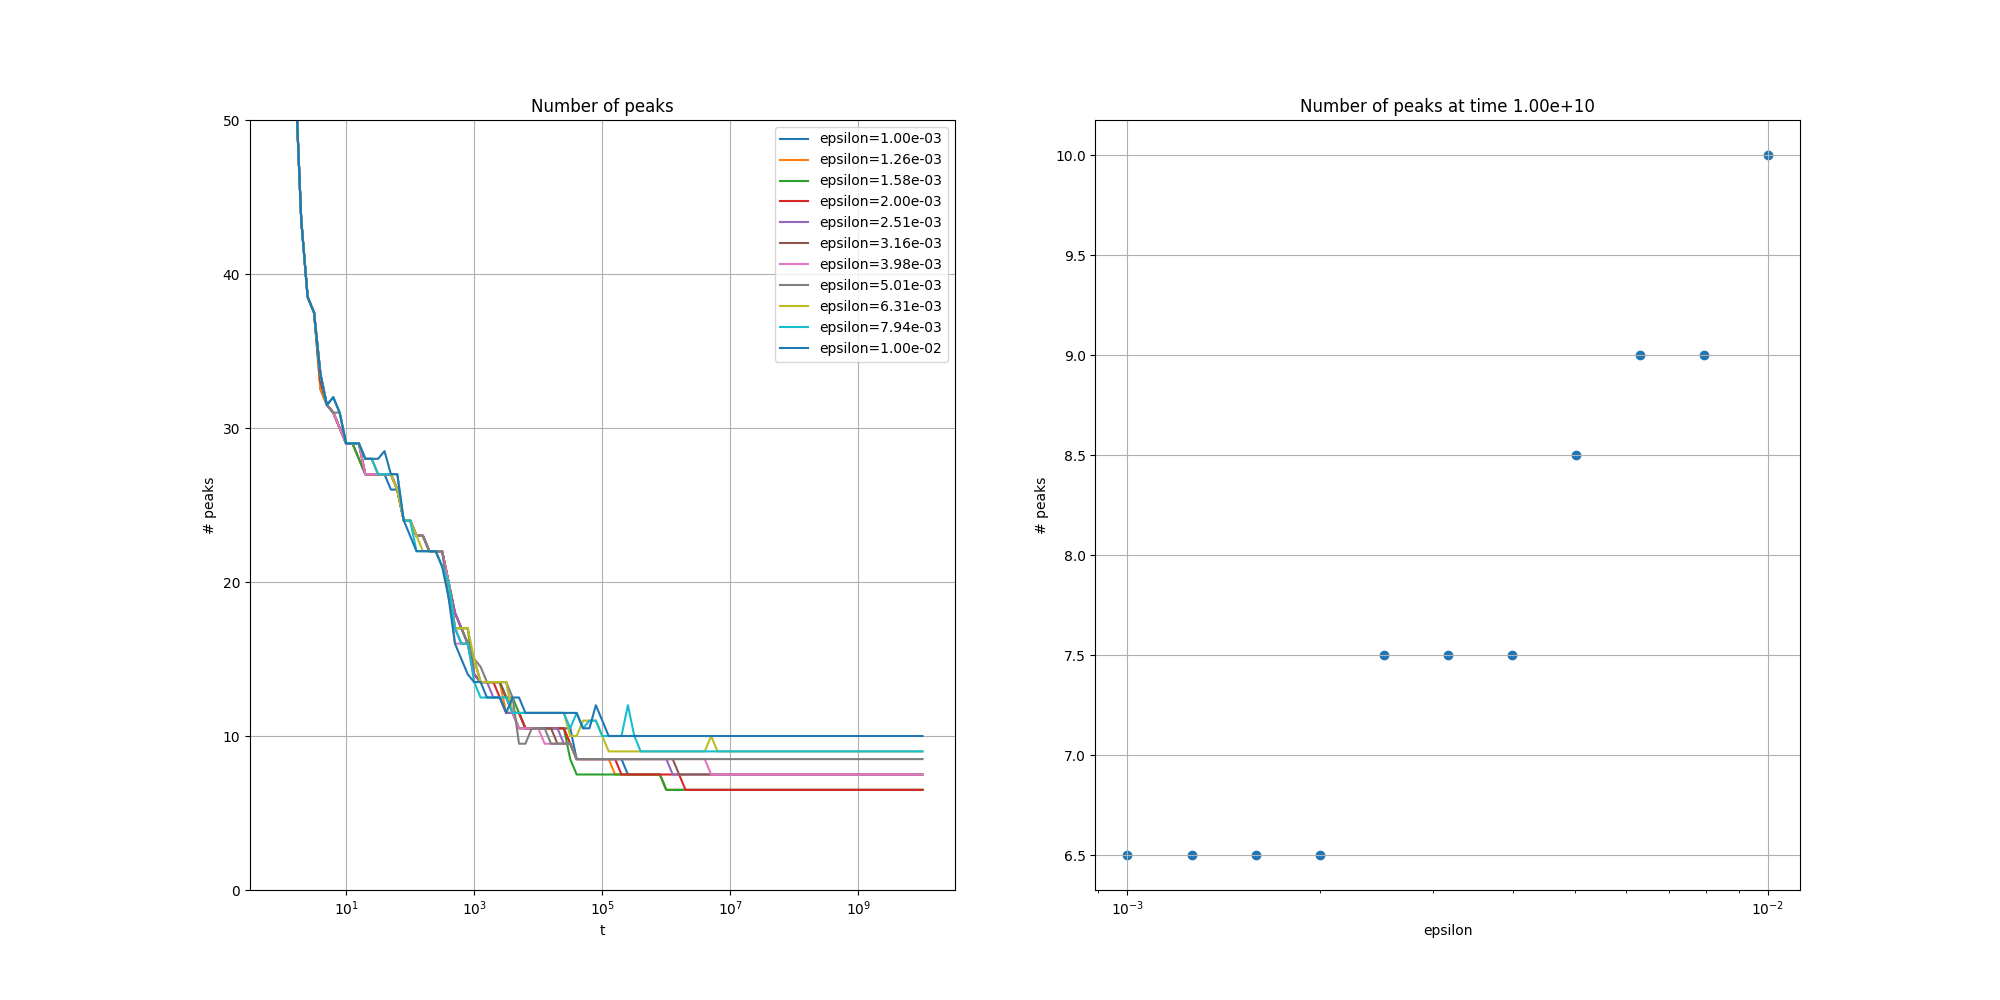

In [11]:
# number of peaks in time @ many epsilon
i = 0
k = -1
fig, axs = plt.subplots(1,2, figsize=(20,10))
ax = axs[0]
for j in range(h5file.shape[1]):
    ax.plot(h5file.t_range, n_peaks_array[i,j], label=f'epsilon={h5file.variables[1]["epsilon"][j]:.2e}')
ax.set_ylim(0, 50)
ax.set_xlabel('t')
ax.set_title(f'Number of peaks')
ax.legend()
ax = axs[1]
ax.scatter(h5file.variables[1]["epsilon"], n_peaks_array[i,:,k])
ax.set_title(f'Number of peaks at time {h5file.t_range[k]:.2e}')
ax.set_xlabel('epsilon')
for ax in axs:
    ax.set_xscale('log')
    ax.set_ylabel('# peaks')
    ax.grid()
plt.show()

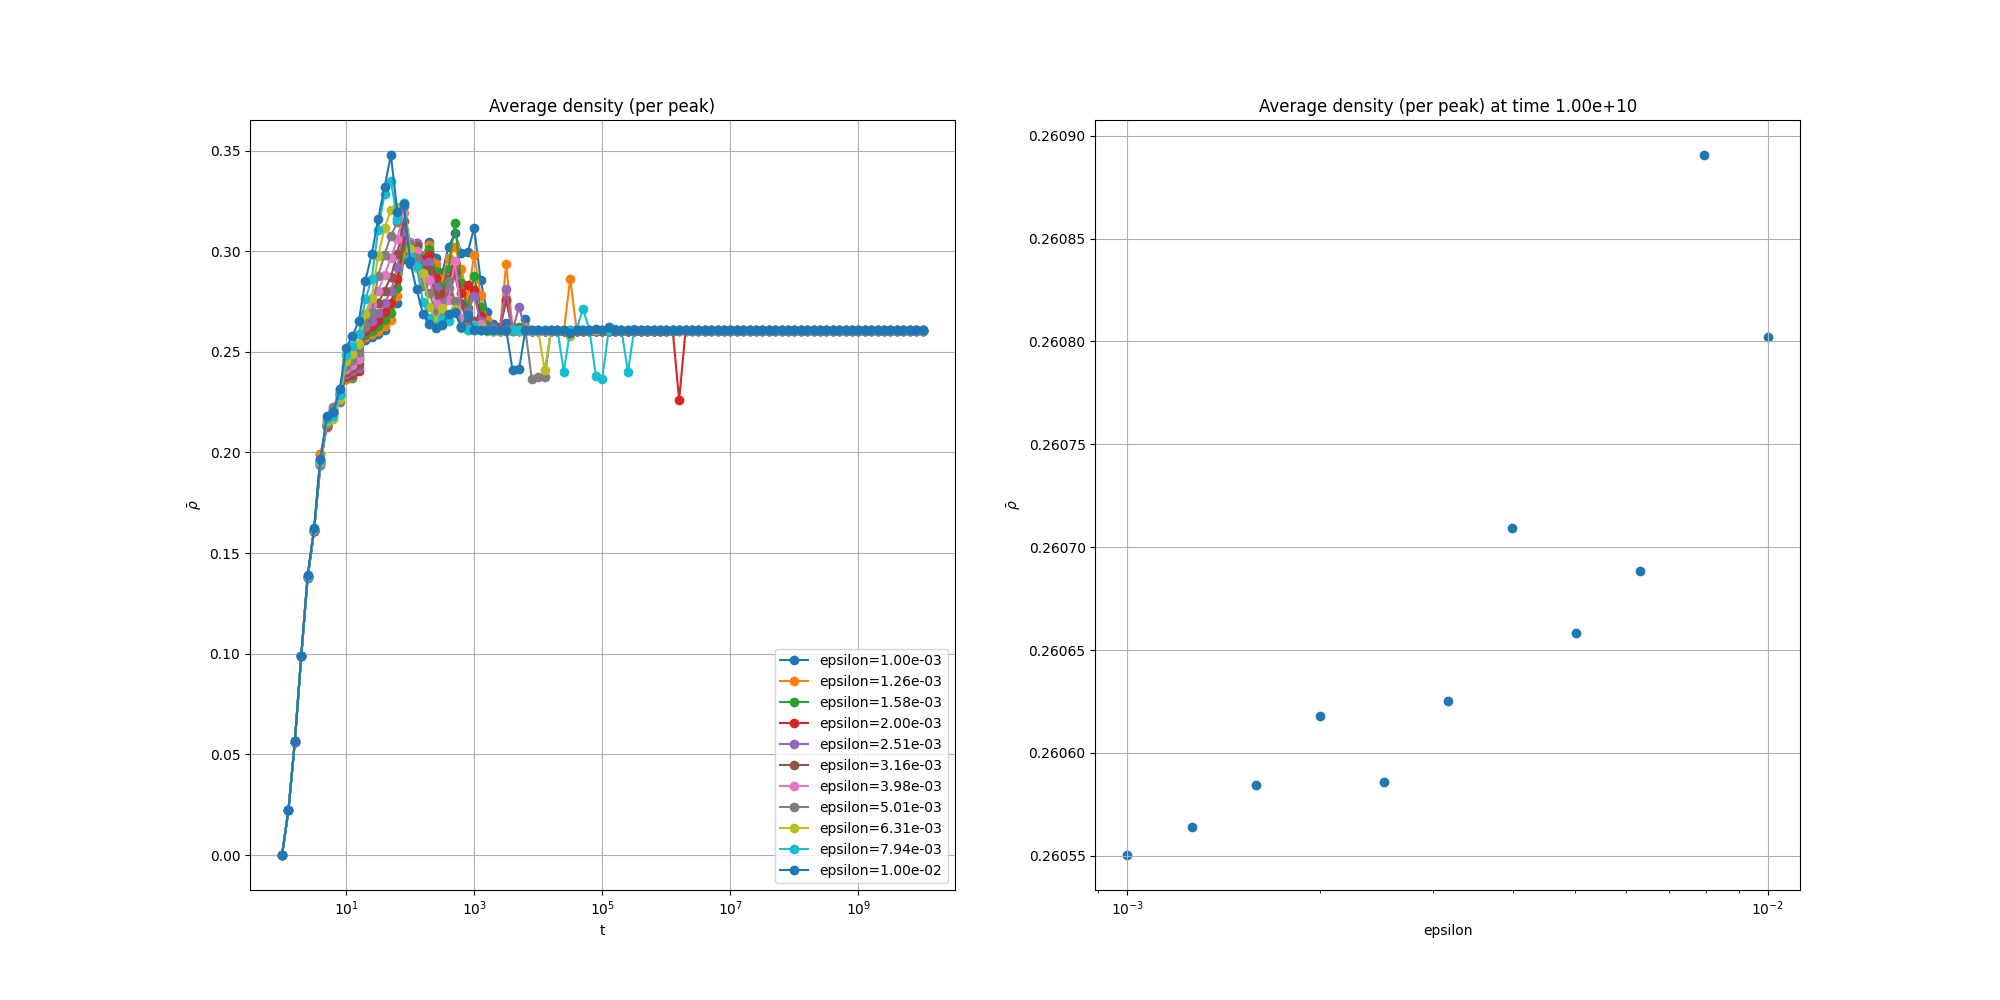

In [14]:
# number of peaks in time @ many epsilon
i = 0
k = -1
fig, axs = plt.subplots(1,2, figsize=(20,10))
ax = axs[0]
rho = np.sum(pde_sol, axis=-1) / h5file.xmax
# per peak normalization
rho /= n_peaks_array
for j in range(h5file.shape[1]):
    ax.plot(h5file.t_range, rho[i,j], '-o', label=f'epsilon={h5file.variables[1]["epsilon"][j]:.2e}')
ax.set_xlabel('t')
ax.set_title(f'Average density (per peak)')
ax.legend()
ax = axs[1]
ax.scatter(h5file.variables[1]["epsilon"], rho[i,:,k])
ax.set_title(f'Average density (per peak) at time {h5file.t_range[k]:.2e}')
ax.set_xlabel('epsilon')
for ax in axs:
    ax.set_xscale('log')
    ax.set_ylabel('$\\bar \\rho$')
    ax.grid()
plt.show()

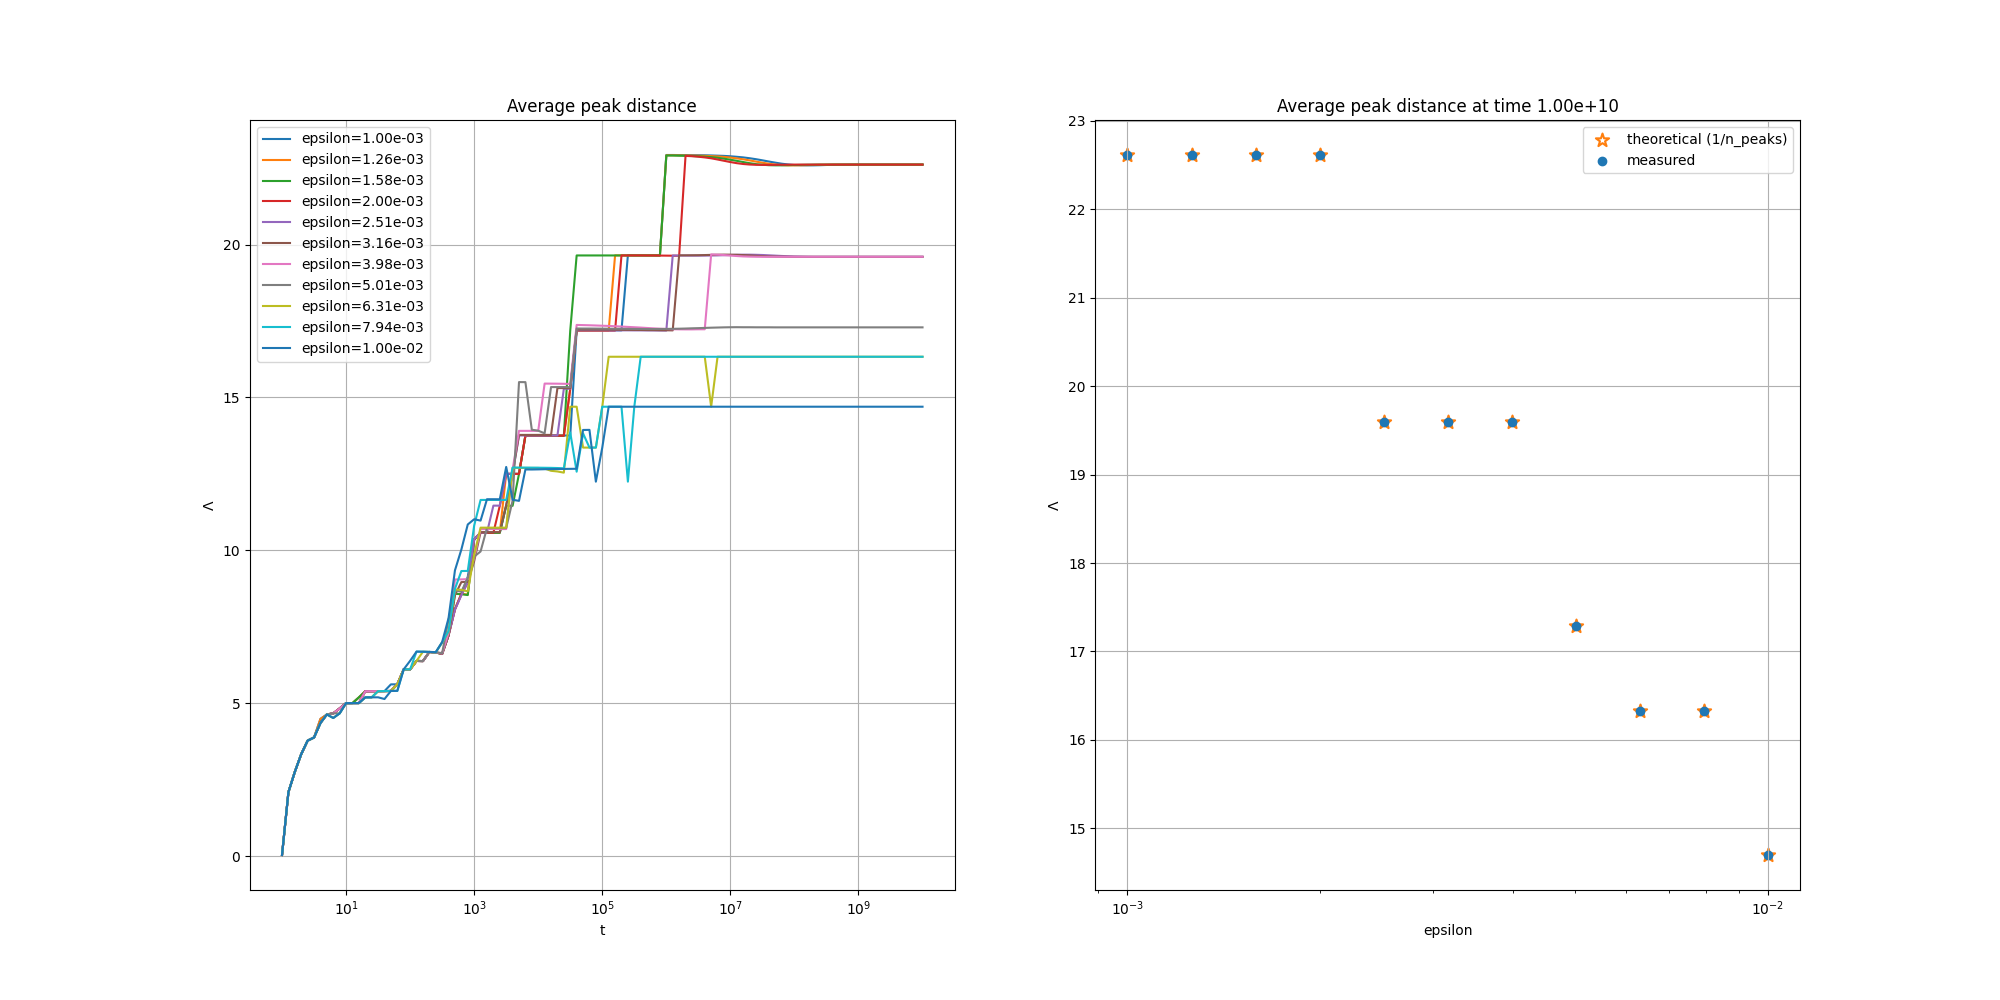

In [32]:
# peaks distance in time @ many epsilon
i = 0
k = -1
fig, axs = plt.subplots(1,2, figsize=(20,10))
ax = axs[0]
for j in range(h5file.shape[1]):
    ax.plot(h5file.t_range, [np.mean(peaks) for peaks in peaks_diff_array[i,j]], label=f'epsilon={h5file.variables[1]["epsilon"][j]:.2e}')
ax.set_xlabel('t')
ax.set_title(f'Average peak distance')
ax = axs[1]
ax.scatter(h5file.variables[1]["epsilon"], h5file.xmax/n_peaks_array[i,:,k], marker='*', s=100, edgecolors='tab:orange', linewidths=1.5, color=(0,0,0,0), label='theoretical (1/n_peaks)')
ax.scatter(h5file.variables[1]["epsilon"], [np.mean(peaks) for peaks in peaks_diff_array[i,:,k]], label='measured')
ax.set_title(f'Average peak distance at time {h5file.t_range[k]:.2e}')
ax.set_xlabel('epsilon')
for ax in axs:
    ax.set_xscale('log')
    ax.set_ylabel('$\\Lambda$')
    ax.legend()
    ax.grid()
plt.show()

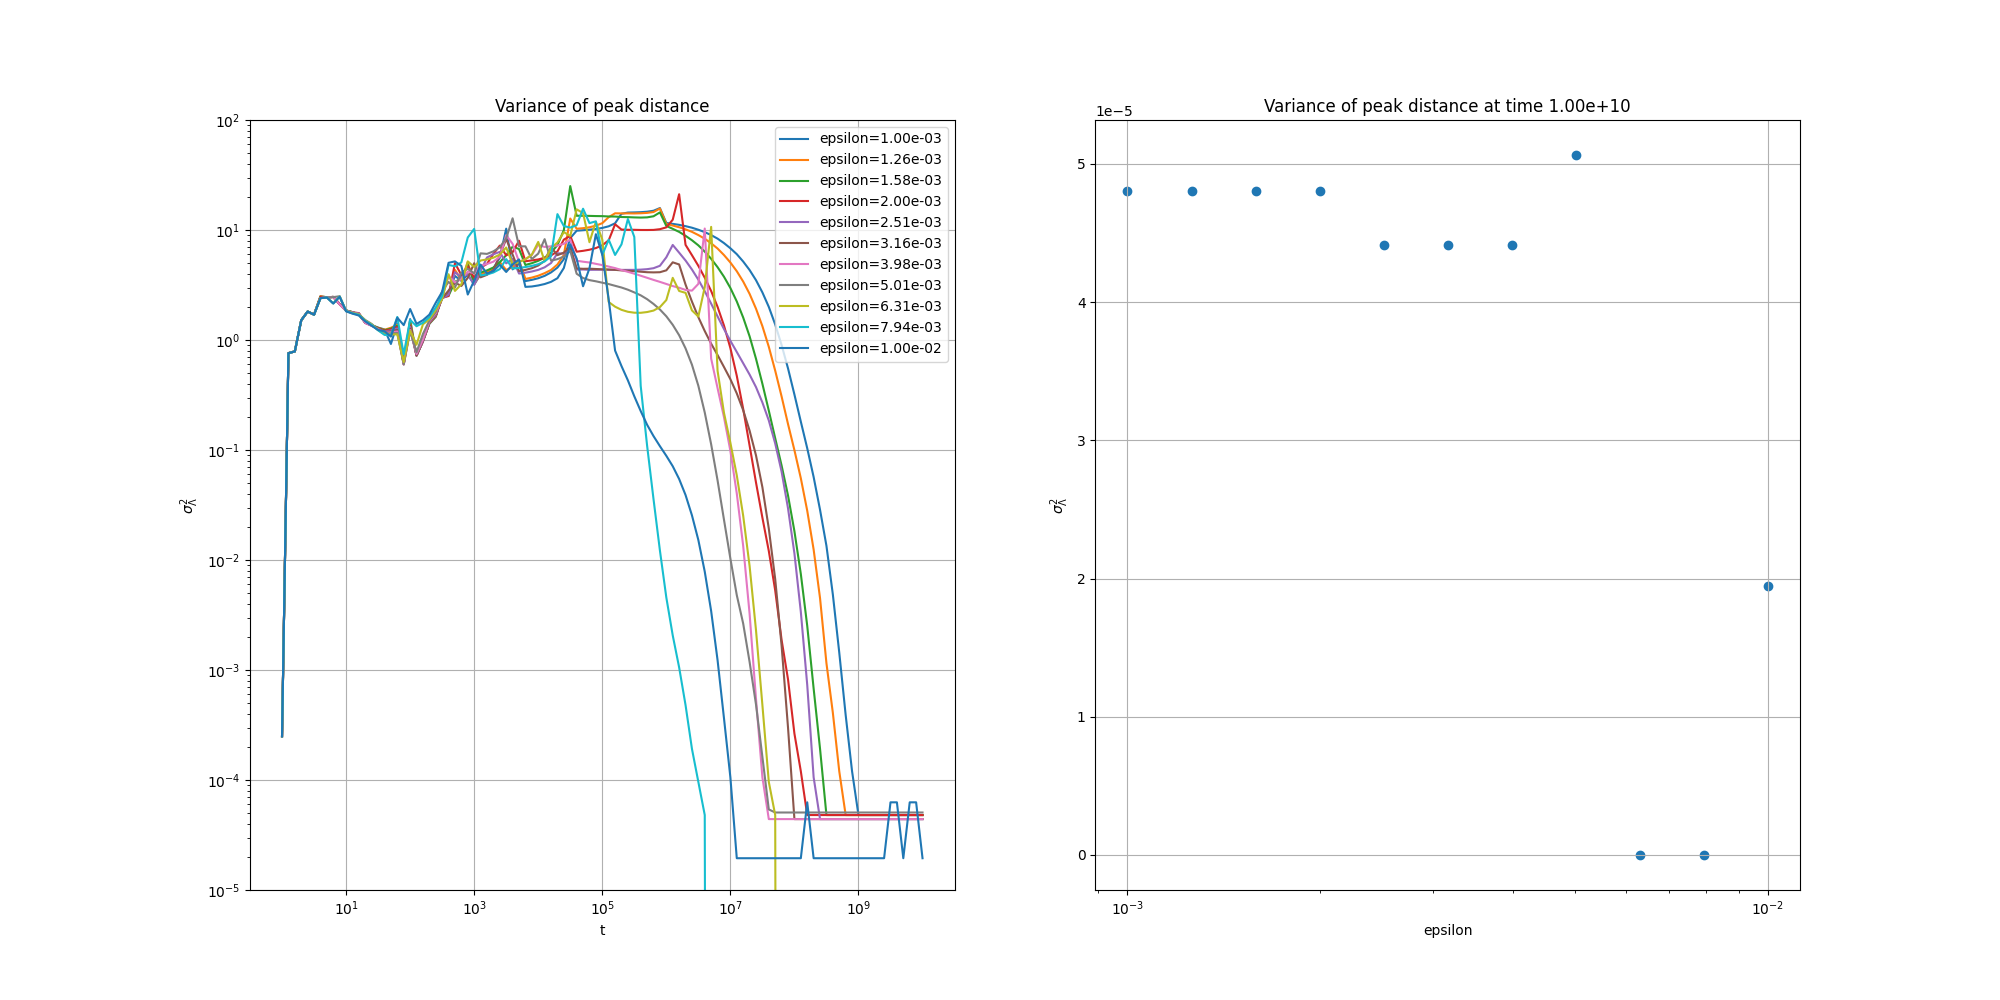

In [33]:
# peaks distance variance in time @ many epsilon
i = 0
k = -1
fig, axs = plt.subplots(1,2, figsize=(20,10))
ax = axs[0]
for j in range(h5file.shape[1]):
    ax.plot(h5file.t_range, [np.var(peaks) for peaks in peaks_diff_array[i,j]], label=f'epsilon={h5file.variables[1]["epsilon"][j]:.2e}')
ax.set_yscale('log')
ax.set_ylim(1e-5,1e2)
ax.set_xlabel('t')
ax.set_title(f'Variance of peak distance')
ax.legend()
ax = axs[1]
ax.scatter(h5file.variables[1]["epsilon"], [np.var(peaks) for peaks in peaks_diff_array[i,:,k]])
ax.set_title(f'Variance of peak distance at time {h5file.t_range[k]:.2e}')
ax.set_xlabel('epsilon')
for ax in axs:
    ax.set_xscale('log')
    ax.set_ylabel('$\\sigma_\\Lambda^2$')
    ax.grid()
plt.show()

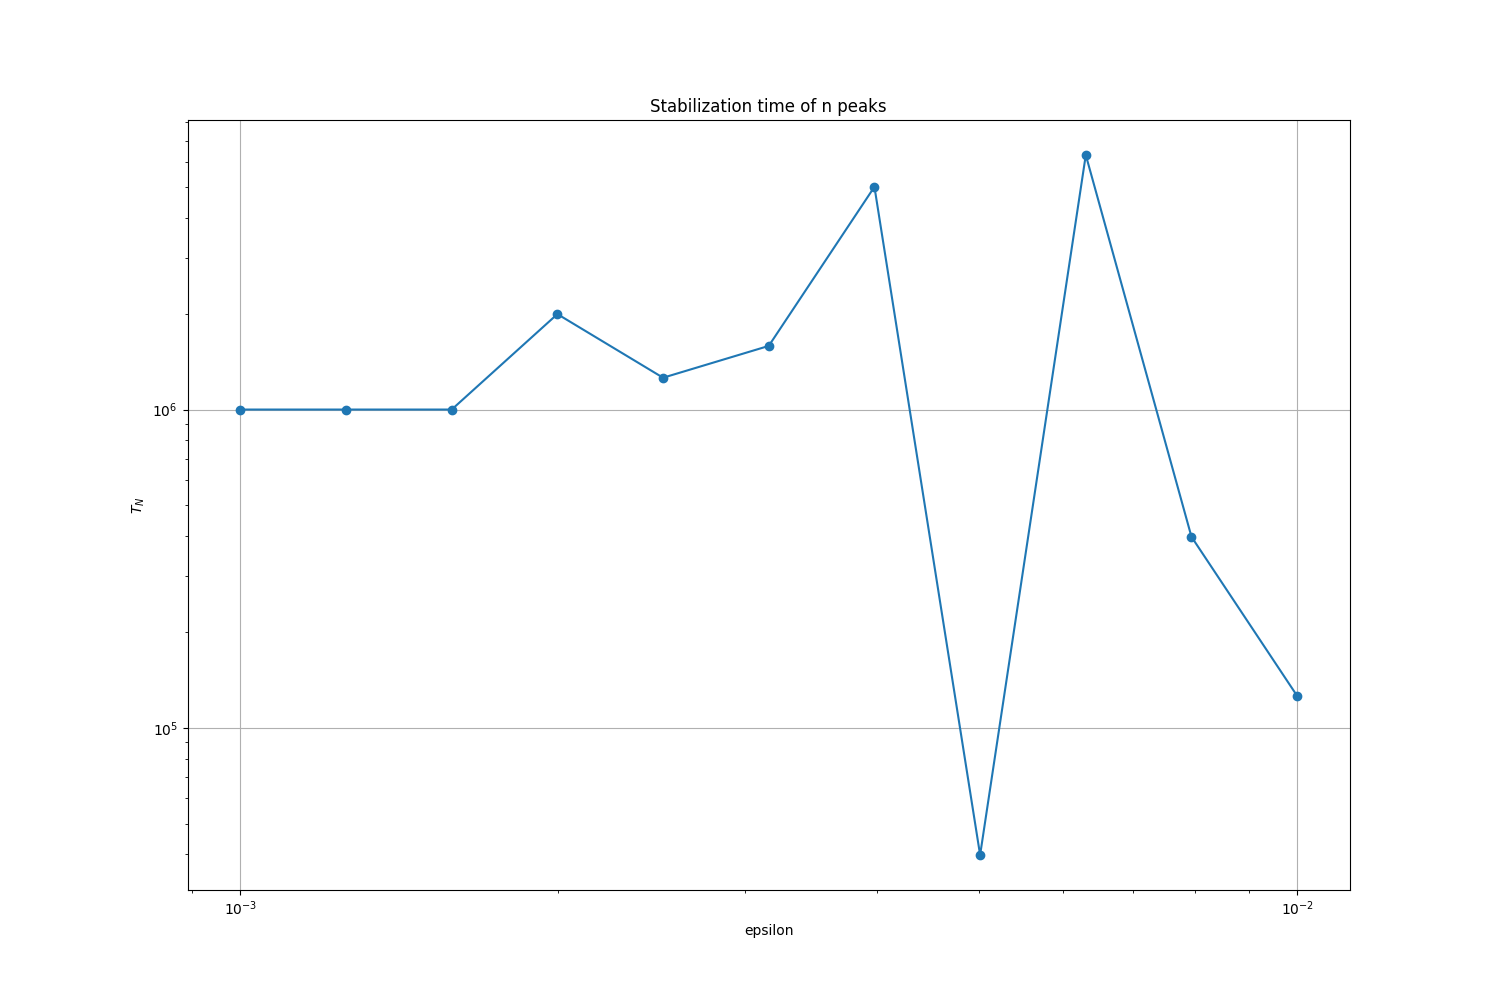

In [34]:
# n peaks stabilization time
i = 0
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(h5file.variables[1]["epsilon"], [h5file.t_range[np.where(np.gradient(n_peaks_array[i,j,:]) != 0.)][-1] for j in range(h5file.shape[1])], '-o')
ax.set_title(f'Stabilization time of n peaks')
ax.set_xlabel('epsilon')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$T_N$')
ax.grid()
plt.show()

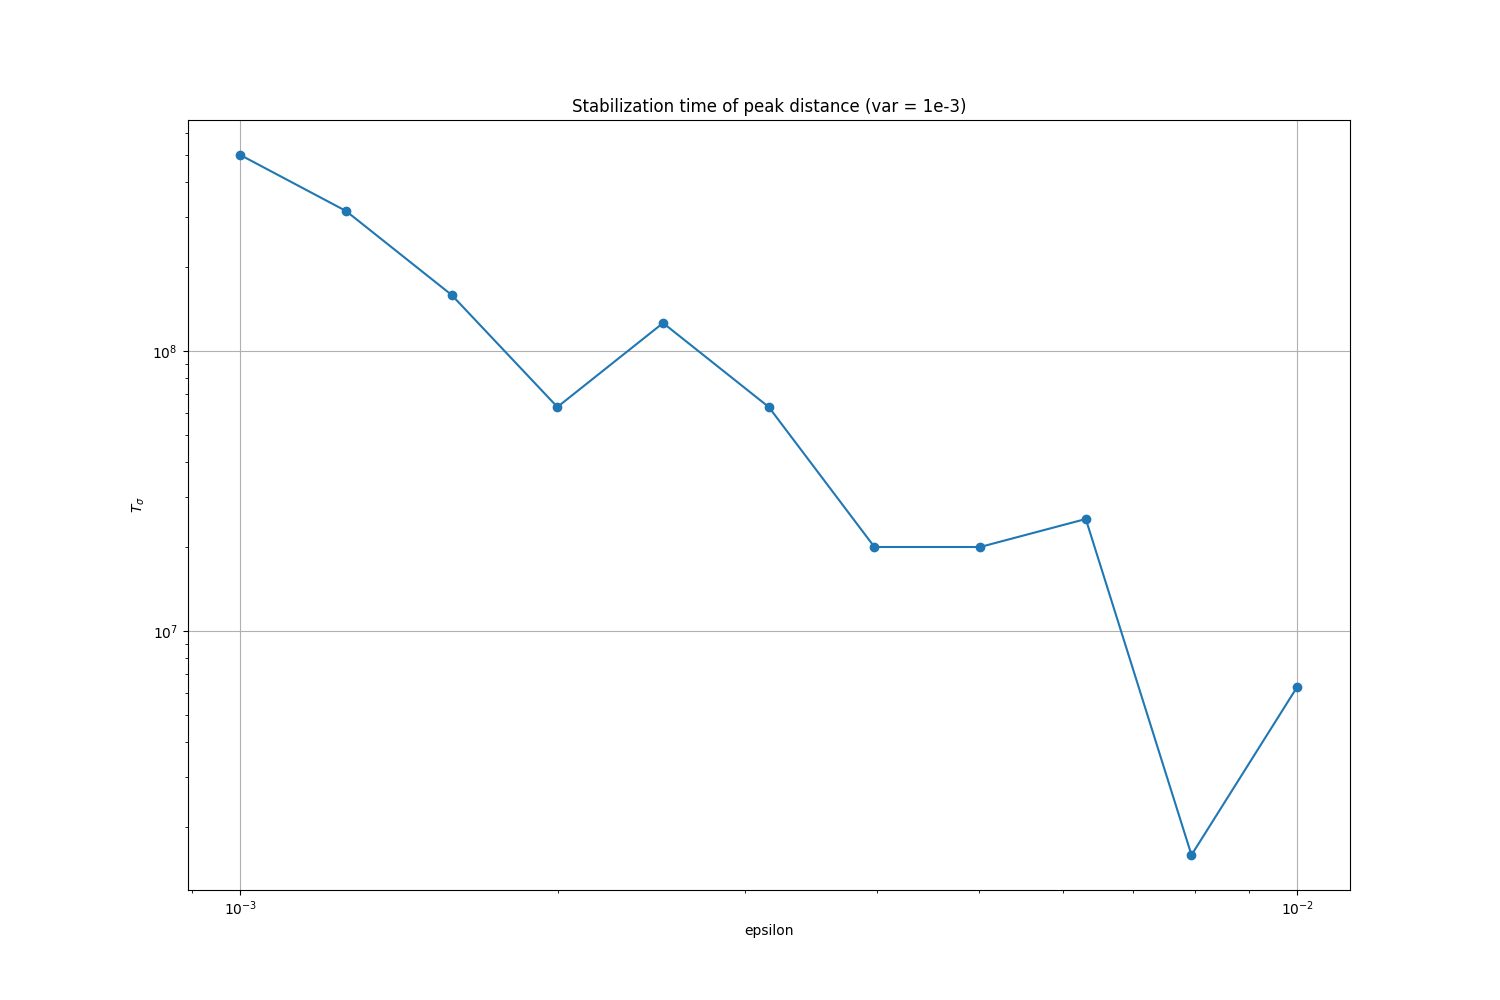

In [35]:
# n peaks stabilization time
i = 0
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(h5file.variables[1]["epsilon"], [h5file.t_range[np.where(np.array([np.var(peaks) for peaks in peaks_diff_array[i,j]]) > 1e-3)][-1] for j in range(h5file.shape[1])], '-o')
ax.set_title(f'Stabilization time of peak distance (var = 1e-3)')
ax.set_xlabel('epsilon')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$T_\\sigma$')
ax.grid()
plt.show()

## Plotting for fix epsilon

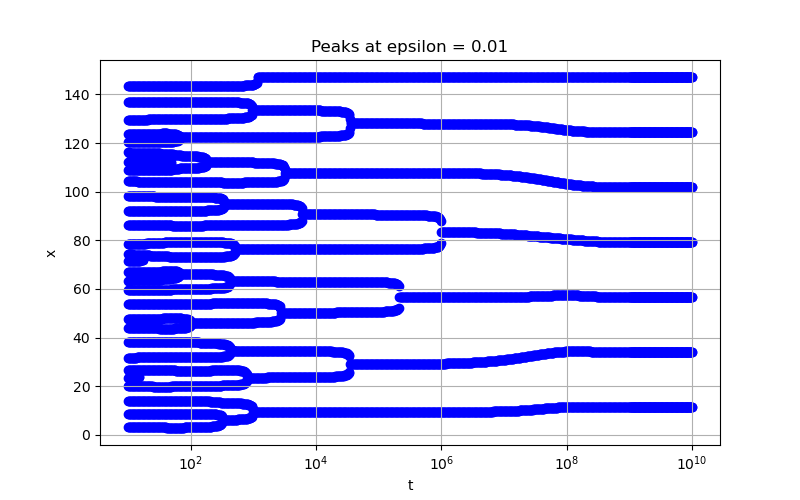

In [48]:
# peaks position in time @ every epsilon
i = 0 # rho variable
j = 0 # epsilon=0.001
plt.close('all')
fig, ax = plt.subplots(h5file.shape[1], figsize=(8,5))
for k in range(h5file.shape[2]-1000, h5file.shape[2], 1):
    ax.scatter([h5file.t_range[k]]*len(peaks_array[i,j,k]), peaks_array[i,j,k], color='b')
ax.set_xscale('log')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title(f'Peaks at epsilon = 0.01')
ax.grid()
plt.show()

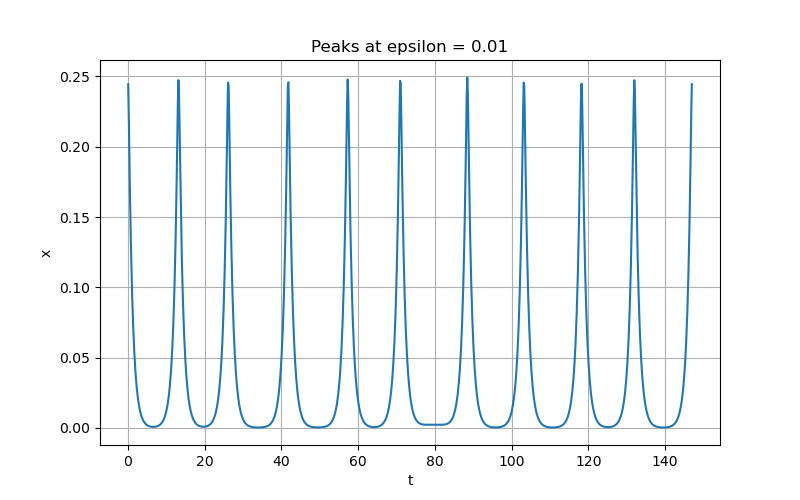

In [31]:
# peaks position in time @ every epsilon
i = 0 # rho variable
j = 0 # epsilon=0.001
k = -1
fig, ax = plt.subplots(h5file.shape[1], figsize=(8,5))
ax.plot(h5file.x_range, pde_sol[i,j,k])
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title(f'Peaks at epsilon = 0.01')
ax.grid()
plt.show()

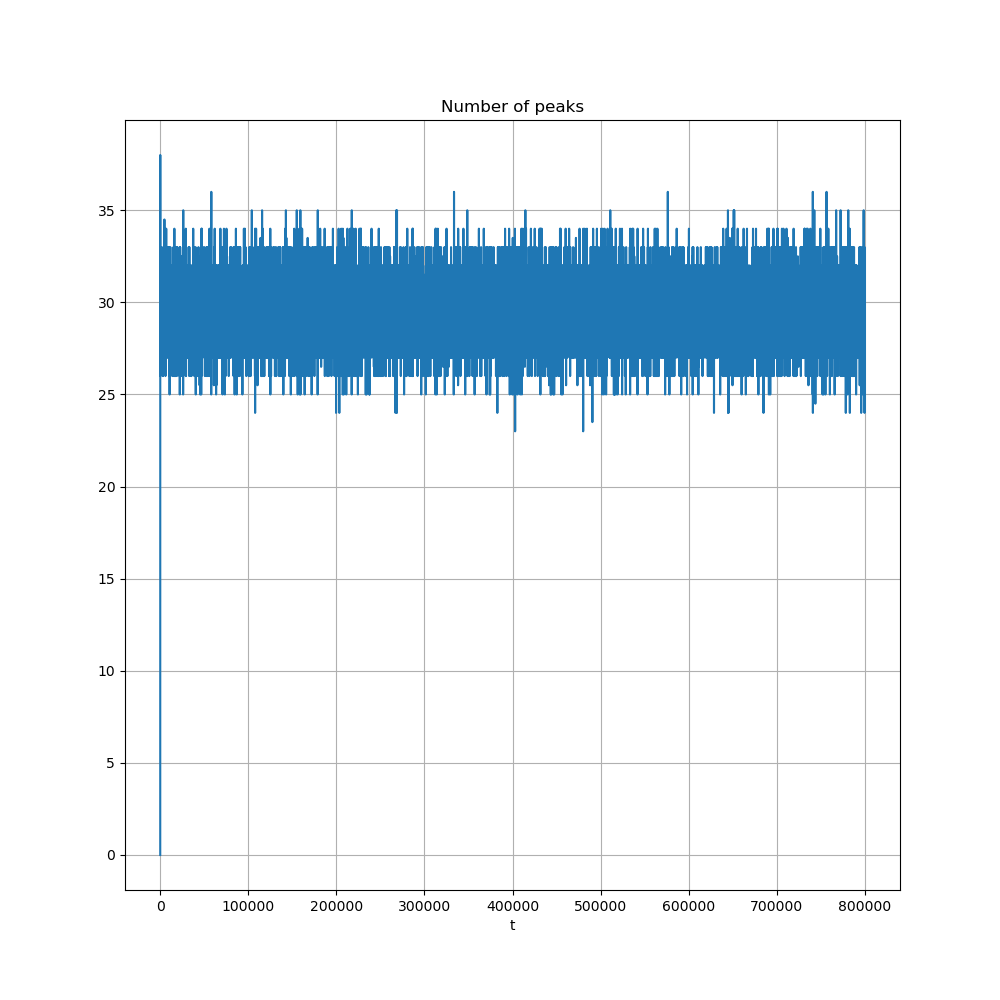

In [29]:
# number of peaks in time @ many epsilon
i = 0
j = 0
fig, ax = plt.subplots(1, figsize=(10,10))
ax.plot(h5file.t_range, n_peaks_array[i,j])
ax.set_xlabel('t')
ax.set_title(f'Number of peaks')
# ax.set_xscale('log')
ax.grid()
plt.show()

/tmp/ipykernel_1690643/2781776718.py:9: RuntimeWarning: divide by zero encountered in divide
  peak_mass = tot_mass / n_peaks_array


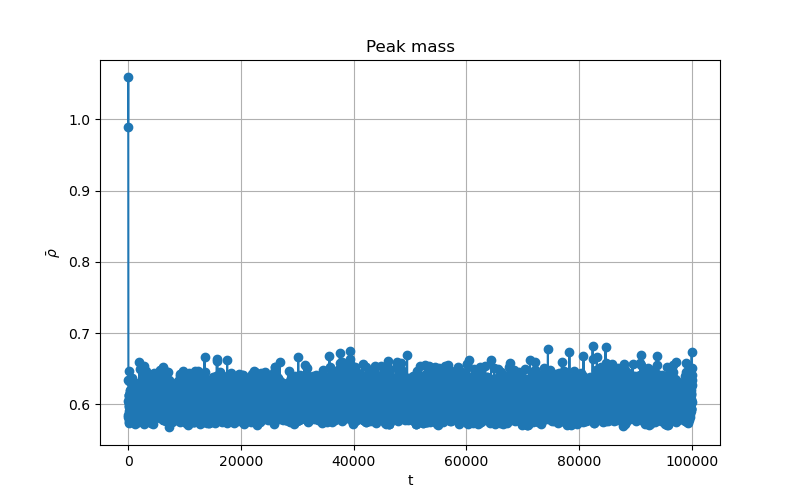

In [20]:
# number of peaks in time @ many epsilon
i = 0
j = 0
k = -1
fig, ax = plt.subplots(1, figsize=(8,5))

tot_mass = np.sum(pde_sol, axis=-1) * h5file.dx
# per peak normalization
peak_mass = tot_mass / n_peaks_array

ax.plot(h5file.t_range, peak_mass[i,j], '-o')
ax.set_xlabel('t')
ax.set_title(f'Peak mass')
ax.set_ylabel('$\\bar \\rho$')
ax.grid()
plt.show()

/home/n/Natan.Dominko/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/n/Natan.Dominko/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


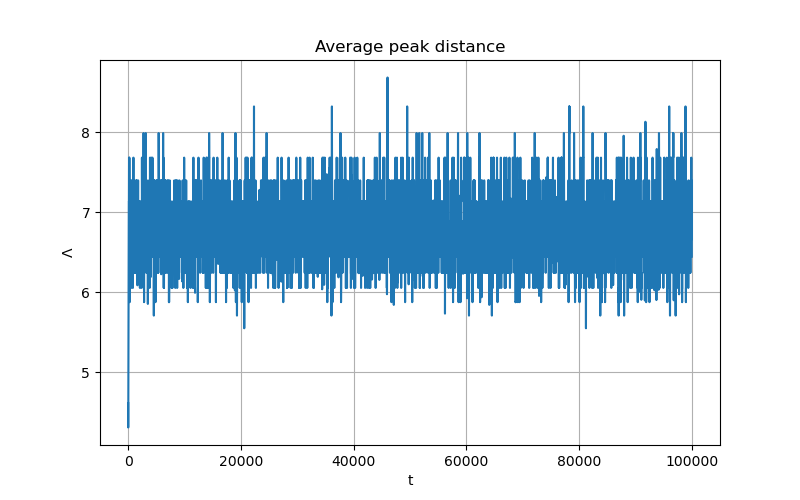

In [15]:
# peaks distance in time @ many epsilon
i = 0
j = 0

fig, ax = plt.subplots(1, figsize=(8,5))
ax.plot(h5file.t_range, [np.mean(peaks) for peaks in peaks_diff_array[i,j]])
ax.set_xlabel('t')
ax.set_title(f'Average peak distance')
ax.set_ylabel('$\\Lambda$')
ax.grid()
plt.show()

/home/n/Natan.Dominko/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/n/Natan.Dominko/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/n/Natan.Dominko/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


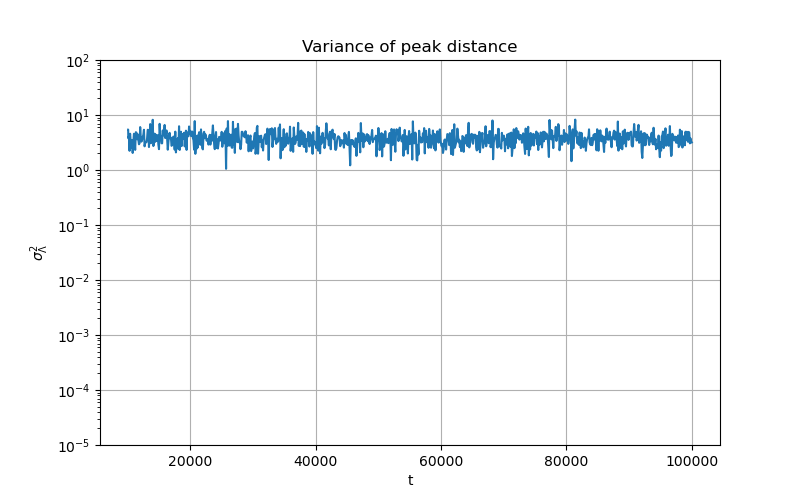

In [23]:
# peaks distance variance in time @ many epsilon
i = 0
j = 0
fig, ax = plt.subplots(1, figsize=(8,5))
ax.plot(h5file.t_range, [np.var(peaks) for peaks in peaks_diff_array[i,j]])
ax.set_yscale('log')
ax.set_ylim(1e-5,1e2)
ax.set_xlabel('t')
ax.set_title(f'Variance of peak distance')
ax.set_ylabel('$\\sigma_\\Lambda^2$')
ax.grid()
plt.show()

## Events analysis

In [13]:
explain = False

In [14]:
def gauss_sums(xrange, peak_locations, peak_widths):
    if type(peak_widths) == list:
        raise TypeError
    else: 
        return np.sum(np.exp(- 0.5 * (xrange[:, np.newaxis] - np.array(peak_locations)[np.newaxis, :])**2 / peak_widths**2), axis=1) / np.sqrt(2 * np.pi) / peak_widths

if explain:
    time = 1112
    
    dx = 0.1
    xrange = np.arange(0, 200, dx)
    sigma = 3.
    
    plt.close('all')
    fig, axs = plt.subplots(3, 1, figsize=(8,8), sharex=True)
    ax = axs[0]
    ax.scatter(peaks_array[0,0,time - 1], - np.ones_like(peaks_array[0,0,time - 1]), label='Peaks at time t-1')
    ax.scatter(peaks_array[0,0,time], np.ones_like(peaks_array[0,0,time]), label='Peaks at time t')
    ax.set_ylim(-1.5, 1.5)
    
    ax = axs[1]
    ax.plot(xrange, gauss_sums(xrange, peaks_array[0,0,time - 1], sigma), label='smoothed peaks time t-1')
    ax.plot(xrange, gauss_sums(xrange, peaks_array[0,0,time], sigma) , label='smoothed peaks time t')
    diff_arr = gauss_sums(xrange, peaks_array[0,0,time], sigma) - gauss_sums(xrange, peaks_array[0,0,time - 1], sigma)
    ax.plot(xrange, diff_arr, label='smoothed difference')
    
    ax = axs[2]
    event_ind = find_peaks(np.abs(diff_arr), height=0.05)[0]
    merge_mask = diff_arr[event_ind] < 0
    ax.scatter(xrange[event_ind][merge_mask], [0]*np.sum(merge_mask), label='Merge event')
    ax.scatter(xrange[event_ind][~merge_mask], [0]*np.sum(~merge_mask), marker='+', label='Emerge event')
    
    for ax in axs:
        ax.grid()
        ax.legend()
    axs[-1].set_xlabel('x')
    plt.tight_layout()
    plt.show()

In [15]:
def get_merge_emerge_spatial(peaks_array, t_range, xrange, sigma, peak_height, outtype='list'):
    if outtype == 'list': 
        merge_events = np.empty_like(peaks_array)[:-1]
        emerge_events = np.empty_like(peaks_array)[:-1]
    elif outtype == 'array':
        merge_events = []
        emerge_events = []
    elif outtype == 'full':
        events = []
    for i,time in enumerate(t_range[1:]):
        # get density change approx
        dndt = gauss_sums(xrange, peaks_array[i], sigma) - gauss_sums(xrange, peaks_array[i-1], sigma)
        # find its peaks
        event_ind = find_peaks(np.abs(dndt), height=peak_height)[0]

        # classify the peaks
        if outtype == 'list': 
            emerge_mask = dndt[event_ind]>0
            emerge_events[i] = xrange[event_ind][emerge_mask]
            merge_events[i]  = xrange[event_ind][~emerge_mask]
        elif outtype == 'array':
            for ind in event_ind:
                if dndt[ind] > 0:
                    emerge_events.append([time, xrange[ind]])
                else:
                    merge_events.append([time, xrange[ind]])
        elif outtype == 'full':
            for ind in event_ind:
                events.append([time, xrange[ind], np.sign(dndt[ind])])
    if outtype == 'full':
        return np.array(events)
    else:
        return np.array(emerge_events), np.array(merge_events)

In [16]:
# plotting all events (M / E classified)
dx = 1
xrange = np.arange(h5file.xmin, h5file.xmax+dx, dx)
emerge_events, merge_events = get_merge_emerge_spatial(peaks_array[0,0,:], h5file.t_range, xrange, sigma=3., peak_height=0.08, outtype='array')

if explain:
    fig, ax = plt.subplots(1, figsize=(8,5))
    merge_events = np.array(merge_events)
    emerge_events = np.array(emerge_events)
    ax.scatter(merge_events[:,0], merge_events[:,1])
    ax.scatter(emerge_events[:,0], emerge_events[:,1], marker='+')
    ax.grid()
    plt.tight_layout()
    plt.show()

In [17]:
all_events = get_merge_emerge_spatial(peaks_array[0,0,:], h5file.t_range, xrange, sigma=3., peak_height=0.08, outtype='full')

In [13]:
n_bins_t = 60
n_bins_x = 20
_eps = 1e-6 # right border inclusive correction
bin_edges_t = np.linspace(0, 1200 - _eps, n_bins_t + 1, endpoint=True)
bin_edges_x = np.linspace(0, 200 - _eps, n_bins_x + 1, endpoint=True)
bin_center_t = 0.5 * (bin_edges_t[1:] + bin_edges_t[:-1])
bin_center_x = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])

binned_x = np.digitize(all_events[:, 1], bin_edges_x)

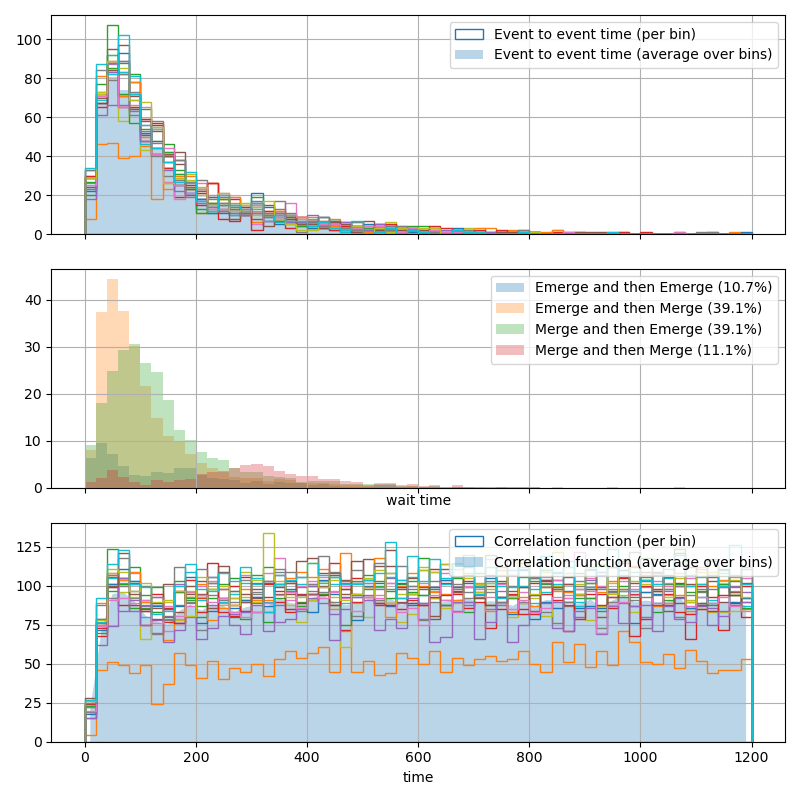

In [60]:
def encode_nonlinear(x, y):
    return 3*x - 2*y - x*y

wait_times_dist = np.zeros((n_bins_t, 2, 2)) 
corr_fct_t = np.zeros(n_bins_t)
plt.close('all')
fig, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
for i in range(n_bins_x):
    bin_mask = binned_x == i
    wait_times = all_events[bin_mask, 0][1:] - all_events[bin_mask, 0][:-1]
    axs[0].hist(wait_times, bin_edges_t, histtype='step', label='Event to event time (per bin)' if i==0 else '')
    
    tag_mask = encode_nonlinear(all_events[bin_mask, 2][1:], all_events[bin_mask, 2][:-1])
    for j, val_j in enumerate([-1, 1]):
        for k, val_k in enumerate([-1, 1]):
            wait_times_dist[:, j, k] += np.histogram(wait_times[tag_mask == encode_nonlinear(val_j, val_k)], bin_edges_t)[0]
            
    autocorr = np.triu(np.tril(all_events[bin_mask, 0][:, np.newaxis] - all_events[bin_mask, 0][np.newaxis, :], k=-1), k=-np.where(all_events[:,0] > bin_edges_t[-1])[0][0]*2)
    autocorr = autocorr.flat
    autocorr = autocorr[autocorr > 0]
    axs[2].hist(autocorr, bin_edges_t, histtype='step', label='Correlation function (per bin)' if i==0 else '')
    corr_fct_t += np.histogram(autocorr, bin_edges_t)[0]

axs[0].bar(bin_center_t, np.sum(wait_times_dist, axis=(1,2))/n_bins_x, width=bin_center_t[1]-bin_center_t[0], alpha=0.3, label='Event to event time (average over bins)')

_tmp_str = ['Emerge', 'Merge']
for j, val_j in enumerate([-1, 1]):
    for k, val_k in enumerate([-1, 1]):
        axs[1].bar(bin_center_t, wait_times_dist[:, j, k]/n_bins_x, width=bin_center_t[1]-bin_center_t[0], alpha=0.3, label=f"{_tmp_str[j]} and then {_tmp_str[k]} ({np.sum(wait_times_dist[:, j, k]*100/np.sum(wait_times_dist, axis=(0,1,2))):3.1f}%)")

axs[2].fill_between(bin_center_t, corr_fct_t/n_bins_x, alpha=0.3, label='Correlation function (average over bins)')
for ax in axs:
    ax.grid()
    # ax.set_yscale('log')
    ax.legend()
axs[1].set_xlabel('wait time')
axs[2].set_xlabel('time')

plt.tight_layout()
plt.show()

In [61]:
autocorr_t = np.triu(np.tril(all_events[:, 0][:, np.newaxis] - all_events[:,0][np.newaxis, :], k=0), k=-np.where(all_events[:,0] > bin_edges_t[-1])[0][0]*2)
autocorr_t = autocorr_t.flat

autocorr_x = np.triu(np.tril(np.abs(all_events[:, 1][:, np.newaxis] - all_events[:,1][np.newaxis, :]), k=0), k=-np.where(all_events[:,0] > bin_edges_t[-1])[0][0]*2)
autocorr_x = autocorr_x.flat

autocorr_t, autocorr_x = autocorr_t[autocorr_t > 0], autocorr_x[autocorr_t > 0]

hist2d,_,_ = np.histogram2d(autocorr_t, autocorr_x, bins=(bin_edges_t, bin_edges_x))

/tmp/ipykernel_2358349/1350030741.py:3: RuntimeWarning: divide by zero encountered in divide
  bin_multiplicity = 1/np.log((bin_edges_x[-1] - bin_edges_x[:-1])/(bin_edges_x[-1] - bin_edges_x[1:]))
/tmp/ipykernel_2358349/1350030741.py:10: RuntimeWarning: divide by zero encountered in divide
  cs = ax.pcolormesh(bin_edges_t, bin_edges_x, hist2d.T/(1+i*(bin_multiplicity-1))[:,np.newaxis])
/tmp/ipykernel_2358349/1350030741.py:18: RuntimeWarning: divide by zero encountered in divide
  ax.plot(bin_center_x, np.sum(hist2d, axis=0)/(1+i*(bin_multiplicity-1)), '-o',label='Correlation function (time average)' + (' corrected' if i else ''))


[19.49572575 18.49549462 17.49523706 16.49494826 15.49462216 14.49425105
 13.4938249  12.49333049 11.49274997 10.49205869  9.49122158  8.49018702
  7.48887569  6.48715919  5.48481495  4.48142012  3.4760595   2.46630346
  1.44269504  0.        ]


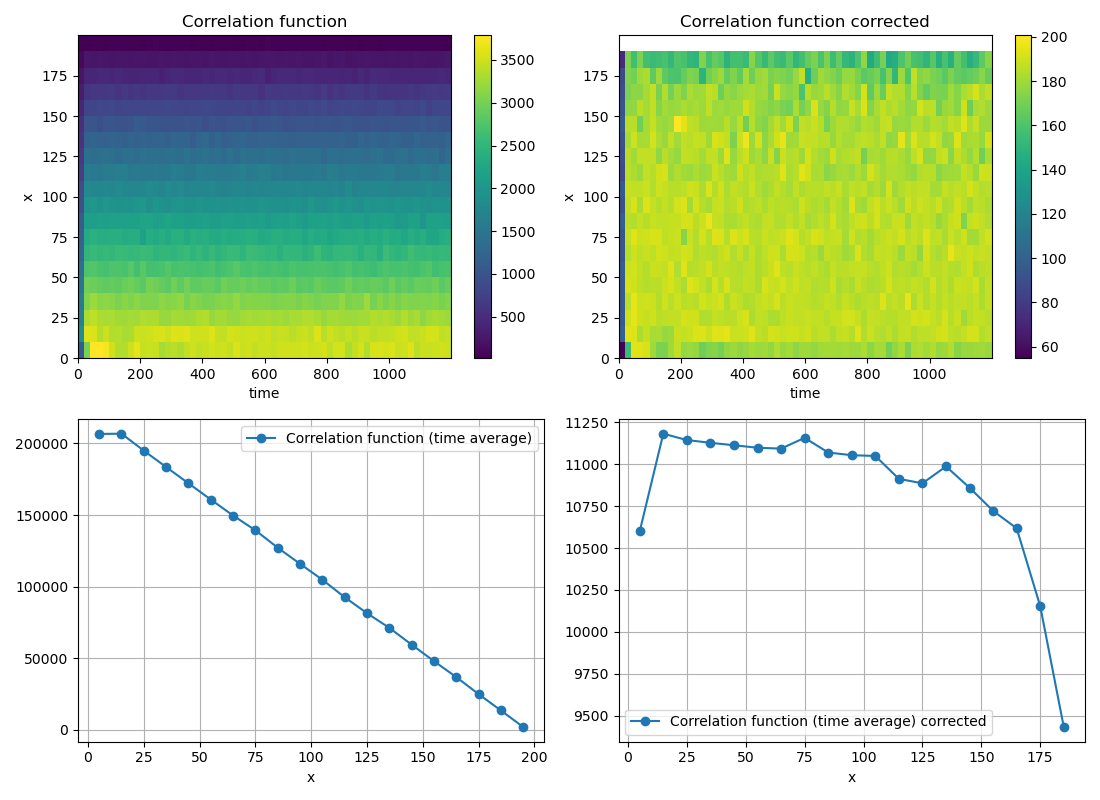

In [62]:
bin_multiplicity = (bin_edges_x[-1] - bin_edges_x[:-1])/(bin_edges_x[1] - bin_edges_x[0])
bin_multiplicity = (bin_edges_x[-1] - bin_center_x)/(bin_edges_x[1] - bin_edges_x[0])
bin_multiplicity = 1/np.log((bin_edges_x[-1] - bin_edges_x[:-1])/(bin_edges_x[-1] - bin_edges_x[1:]))

print(bin_multiplicity)
plt.close('all')
fig, axs = plt.subplots(2,2, figsize=(11,8))
for i in range(2):
    ax = axs[0,i]
    cs = ax.pcolormesh(bin_edges_t, bin_edges_x, hist2d.T/(1+i*(bin_multiplicity-1))[:,np.newaxis])
    # cs = ax.pcolormesh(bin_edges_t, bin_edges_x, hist2d.T/(1+i*(bin_edges_x[-1] - bin_center_x))[:,np.newaxis])
    cbar = fig.colorbar(cs, ax=ax)
    ax.set_xlabel('time')
    ax.set_ylabel('x')
    ax.set_title('Correlation function' + (' corrected' if i else ''))
    
    ax = axs[1,i]
    ax.plot(bin_center_x, np.sum(hist2d, axis=0)/(1+i*(bin_multiplicity-1)), '-o',label='Correlation function (time average)' + (' corrected' if i else ''))
    ax.grid()
    ax.legend()
    ax.set_xlabel('x')
plt.tight_layout()
plt.show()

### Emerge events & peak distance

In [70]:
from scipy.stats import gaussian_kde
def get_alpha_p_samples(all_events, peaks_array, i=0, j=0):
    n_useless, n_useful = 0, 0
    
    emerge_peak_distance, emerge_v = [], []
    
    # loop over emerge events
    for t_event, x_event, _ in all_events[all_events[:,2] == 1.]:
        # get time index 
        k = int((t_event - h5file.tmin)/h5file.dt) - 1
        # skip first 10 timesteps
        if k < 10: continue
        # find nearest peaks to x at previous time
        ind_sort = np.argsort(np.abs(peaks_array[i,j,k-1] - x_event))
        # take nearest two
        near1 = peaks_array[i,j,k-1][ind_sort[0]] - x_event
        near2 = peaks_array[i,j,k-1][ind_sort[1]] - x_event
        # check they are on opposite sides of the emerge event
        if near1*near2 > 0:
            n_useless += 1
        else:
            n_useful += 1
            emerge_peak_distance.append(np.abs(near1 - near2))
            try:
                speed0 = (peaks_array[i,j,k-1][ind_sort[0]] - peaks_array[i,j,k-6][ind_sort[0]]) / h5file.dt / 5
                speed1 = (peaks_array[i,j,k-1][ind_sort[1]] - peaks_array[i,j,k-6][ind_sort[1]]) / h5file.dt / 5
            except:
                speed0 = np.nan
                speed1 = np.nan
            emerge_v.append(speed0 * np.sign(near1) + speed1 * np.sign(near2))
    print(f"Found {n_useful} events with {n_useless} discarded as non-emerge events.")
    return np.array(emerge_peak_distance), np.array(emerge_v)
    
def KDE_with_error(data, x_eval, bandwidth, n_bootstraps):
    # Perform KDE
    kde = gaussian_kde(data, bw_method=bandwidth)
    pdf = kde.evaluate(x_eval)
    
    # Bootstrap to estimate the errors
    bootstrap_pdfs = np.zeros((n_bootstraps, len(x_eval)))
    
    for i in tqdm(range(n_bootstraps)):
        sample = np.random.choice(data, size=len(data), replace=True)
        kde_sample = gaussian_kde(sample, bw_method=bandwidth)
        bootstrap_pdfs[i, :] = kde_sample.evaluate(x_eval)
    
    # Calculate the standard error of the KDE estimates
    pdf_std_error = np.std(bootstrap_pdfs, axis=0)
    return pdf, pdf_std_error

In [71]:
emerge_peak_distance, emerge_v = get_alpha_p_samples(all_events, peaks_array, i, j)

Found 6798 events with 15 discarded as non-emerge events.


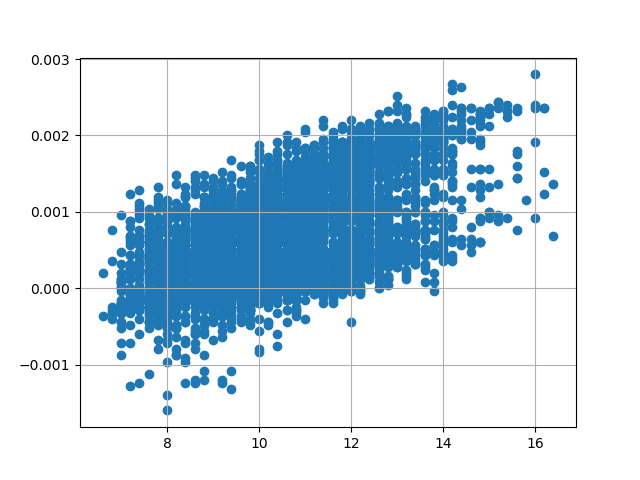

In [73]:
fig, ax = plt.subplots()
ax.scatter(emerge_peak_distance, emerge_v/100)
# ax.hist(emerge_peak_distance, color='k', alpha=0.2, density=True)
# ax.hist2d(emerge_peak_distance, emerge_v, bins=(np.arange(6, 20, 0.5), np.linspace(0.2, 1.5, 30)))
ax.grid()
plt.show()

In [21]:
# peak distance time average hist - prepare data
i = 0
j = 0
bandwidth = None
n_bootstraps = 100

peaks_diff_array_flat = np.array([item for sublist in peaks_diff_array[i,j,:] for item in sublist])
x_range = np.linspace(0, np.max(peaks_diff_array_flat), 100)
p_lambda, p_lambda_error = KDE_with_error(peaks_diff_array_flat, x_range, bandwidth, n_bootstraps)

emerge_peak_distance, emerge_v = get_alpha_p_samples(all_events, peaks_array, i, j)
p_lambda_emerge, p_lambda_emerge_error = KDE_with_error(emerge_peak_distance, x_range, bandwidth, n_bootstraps)

# rescale 
_factor = len(emerge_peak_distance) / len(peaks_diff_array_flat)
alpha_P, alpha_P_error = _factor * p_lambda_emerge, _factor * p_lambda_emerge_error

alpha = alpha_P / (p_lambda + 1e-8)
alpha_error = alpha * np.sqrt((p_lambda_error/p_lambda)**2 + (alpha_P_error/alpha_P)**2)

100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


Found 6798 events with 15 discarded as non-emerge events.


100%|██████████| 100/100 [00:00<00:00, 130.97it/s]


In [16]:
# fitting
from scipy.optimize import curve_fit

alpha_mask = ~np.isnan(alpha)

alpha_fit = lambda x, a, b: np.maximum((x-a)*b, 0)
alpha_fit_params = curve_fit(alpha_fit, x_range[alpha_mask], alpha[alpha_mask], p0=(7.5, 0.5), sigma=alpha_error)[0]
print(f'alpha fit gives lambda split: {alpha_fit_params[0]:.2f} and slope {alpha_fit_params[1]:.3f}')

lambda_split_henrik = 7.46
alpha_fit2 = lambda x, b: np.maximum((x-lambda_split_henrik)*b, 0)
alpha_fit_params2 = curve_fit(alpha_fit2, x_range[alpha_mask], alpha[alpha_mask], p0=(0.5), sigma=alpha_error)[0]
print(f'alpha fit with fix lambda split {lambda_split_henrik:.2f}: slope {alpha_fit_params2[0]:.3f}')


lambda_split_half = lambda_split_henrik / 2
# get low lambda exponential parameters:
log_p_mask = (x_range > lambda_split_half/4)*(x_range < lambda_split_half)*(p_lambda > 0)
log_p_lambda = np.log(p_lambda)
log_p_fit = lambda x, a, b: a + b*x
log_p_fit_params = curve_fit(log_p_fit, x_range[log_p_mask], log_p_lambda[log_p_mask])[0]
print(f"log slope at small lambda = {log_p_fit_params[1]:.2f}")

# supposing we now know a (slope of alpha) we can estimate V (final constant value of v_merge)
log_p_mask2 = (x_range > lambda_split_henrik)*(p_lambda > 0)
log_p_fit2 = lambda x, a, b: -0.5*a*(x-lambda_split_henrik)**2 + b
log_p_fit_params2 = curve_fit(log_p_fit2, x_range[log_p_mask2], log_p_lambda[log_p_mask2], p0=(3, -2), sigma=log_p_lambda[log_p_mask2]**2)[0]
print(f"v_merge(infinity) = {alpha_fit_params2[0]/log_p_fit_params2[0]/2}")

alpha fit gives lambda split: 7.47 and slope 0.037
alpha fit with fix lambda split 7.46: slope 0.036
log slope at small lambda = 1.16
v_merge(infinity) = 0.08308567600631152


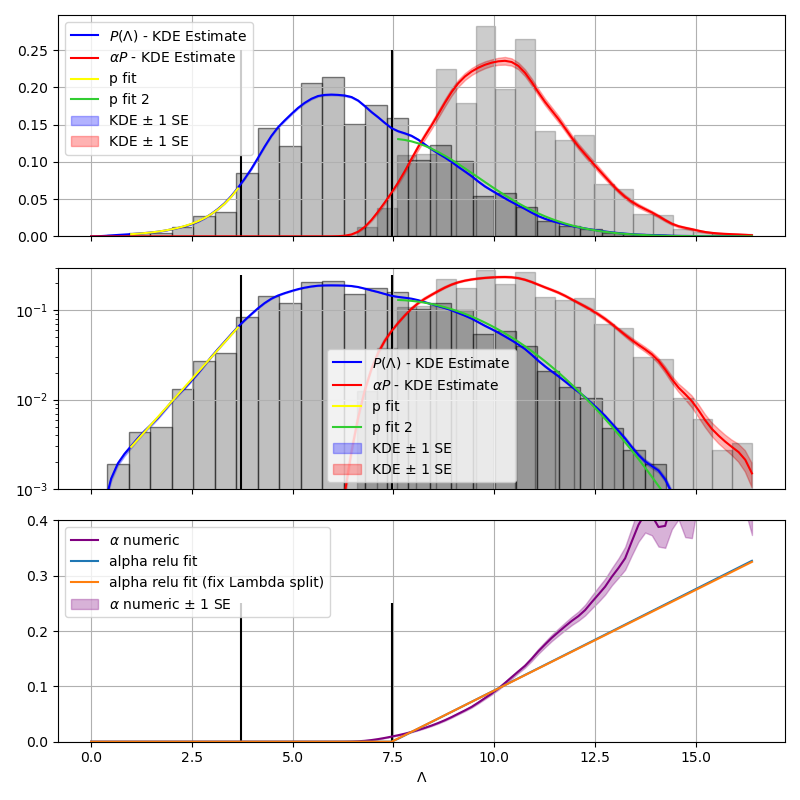

In [17]:
# peak distance time average hist - plot
plt.close('all')
fig, axs = plt.subplots(3,1, figsize=(8,8), sharex=True)

for ax in [axs[0], axs[1]]:
    ax.plot(x_range, p_lambda, label='$P(\\Lambda)$ - KDE Estimate', color='blue')
    ax.hist(peaks_diff_array_flat, bins=30, density=True, alpha=0.5, color='gray', edgecolor='black')
    ax.fill_between(x_range, p_lambda - p_lambda_error, p_lambda + p_lambda_error, color='blue', alpha=0.3, label='KDE ± 1 SE')
    
    ax.plot(x_range, p_lambda_emerge, label='$\\alpha P$ - KDE Estimate', color='red')
    ax.hist(emerge_peak_distance, bins=20, density=True, alpha=0.2, color='black', edgecolor='black')
    ax.fill_between(x_range, p_lambda_emerge - p_lambda_emerge_error, p_lambda_emerge + p_lambda_emerge_error, color='red', alpha=0.3, label='KDE ± 1 SE')

    ax.plot(x_range[log_p_mask], np.exp(log_p_fit(x_range[log_p_mask], *log_p_fit_params)), color='yellow', label='p fit')
    ax.plot(x_range[log_p_mask2], np.exp(log_p_fit2(x_range[log_p_mask2], *log_p_fit_params2)), color='limegreen', label='p fit 2')

ax = axs[1]
ax.set_yscale('log')
ax.set_ylim(1e-3,0.3)

ax = axs[2]
ax.plot(x_range, alpha, color='purple', label='$\\alpha$ numeric')
ax.fill_between(x_range, alpha - alpha_error, alpha + alpha_error, color='purple', label='$\\alpha$ numeric ± 1 SE', alpha=0.3)
ax.plot(x_range, alpha_fit(x_range, *alpha_fit_params), label='alpha relu fit')
ax.plot(x_range, alpha_fit2(x_range, *alpha_fit_params2), label='alpha relu fit (fix Lambda split)')

# ax.set_yscale('log')
ax.set_xlabel('$\Lambda$')
ax.set_ylim(0, 0.4)

for ax in axs:
    ax.grid()
    ax.legend()
    ax.vlines([lambda_split_henrik],0, 0.25, 'k')
    ax.vlines([lambda_split_henrik/2],0, 0.25, 'k')
plt.tight_layout()
plt.show()

/home/n/Natan.Dominko/Documents/code/peaks_analysis/MFKSSteadyState.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  av_int = solve_ivp(lambda t, y: rate(t, lbd_spl, r) / v_Mss(t, g_avg, kappa, k, eps), t_span=(lbd_spl, lbd_upper), y0=[0.0], dense_output=True)
/usr/lib64/python3.9/site-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in divide
  return norm(self._estimate_error(K, h) / scale)
/home/n/Natan.Dominko/Documents/code/peaks_analysis/MFKSSteadyState.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  av_int = solve_ivp(lambda t, y: rate(t, lbd_spl, r) / v_Mss(t, g_avg, kappa, k, eps), t_span=(lbd_spl, lbd_upper), y0=[0.0], dense_output=True)


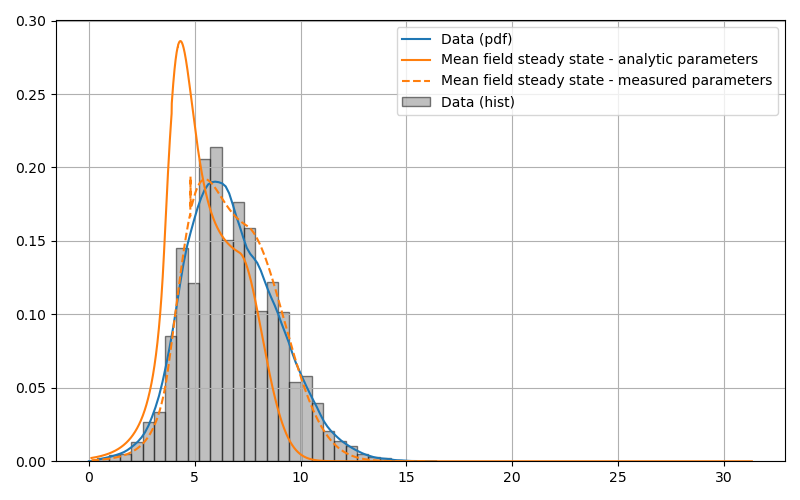

In [30]:
# peak distance time average hist - plot
plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(8,5))

ax.plot(x_range, p_lambda, label='Data (pdf)')
ax.hist(peaks_diff_array_flat, bins=30, density=True, alpha=0.5, color='gray', edgecolor='black', label='Data (hist)')
# ax.fill_between(x_range, p_lambda - p_lambda_error, p_lambda + p_lambda_error, color='blue', alpha=0.3, label='KDE ± 1 SE')

def peak_mass(Drho, Dc, T):
    return np.sqrt(12 * Drho * Dc / T)

def _lbd_spl_eps(eps):
    if eps == 0.0:
        return np.inf 
    else:
        return np.exp(1.13734914) * eps**(-0.3579829)
lbd_spl_eps = np.vectorize(_lbd_spl_eps)

def reparameterize(Drho, Dc, T, epsilon, r):
    M = peak_mass(Drho, Dc, T)
    kappa = 1 / (1 / 4 / np.sqrt(Dc) + 1 / M / T)
    k = 1 / np.sqrt(Dc) 
    eps = 4 * epsilon * np.exp(-T * M / 2 / Drho / np.sqrt(Dc))
    lbd_spl = lbd_spl_eps(epsilon)
    return kappa, k, eps, lbd_spl, r

Drho = 0.1
Dc = 1.0
T = 5.0
epsilon = 1e-1
r = 3.6e-2

from MFKSSteadyState import get_P_ss, parameter_control
kappa, k, eps, lbd_spl, r = reparameterize(Drho, Dc, T, epsilon, r)
if parameter_control(kappa, k, eps, lbd_spl):
    lbd_array, P_array = get_P_ss(31.32, kappa, k, eps, lbd_spl, r, dx=1e-2)
    ax.plot(lbd_array, P_array, label='Mean field steady state - analytic parameters')


def _lbd_spl_eps(eps):
    if eps == 0.0:
        return np.inf 
    if eps == 0.1:
        return 7.46
    else:
        return np.exp(1.13734914) * eps**(-0.3579829)
lbd_spl_eps = np.vectorize(_lbd_spl_eps)


Drho = 0.1
Dc = 1/1.16**2
T = 5.0
epsilon = 1e-1
r = 3e-3

from MFKSSteadyState import get_P_ss, parameter_control
kappa, k, eps, lbd_spl, r = reparameterize(Drho, Dc, T, epsilon, r)
if parameter_control(kappa, k, eps, lbd_spl):
    lbd_array, P_array = get_P_ss(16.0, kappa, k, eps, lbd_spl, r, dx=1e-2)
    ax.plot(lbd_array, P_array, '--C1', label='Mean field steady state - measured parameters')


ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

In [31]:
ax.set_xlim(0,15)

(0.0, 15.0)

## Peak distances distribution

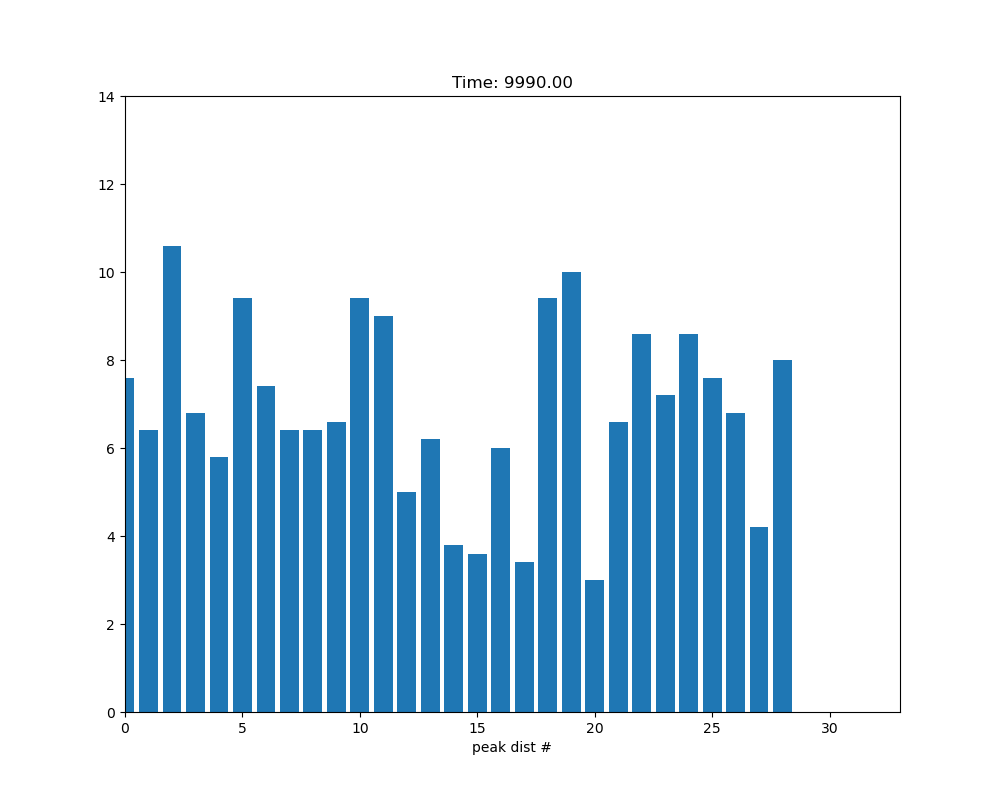

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x145f9e2e8f70>>
Traceback (most recent call last):
  File "/home/n/Natan.Dominko/.local/lib/python3.9/site-packages/tornado/ioloop.py", line 937, in _run
    val = self.callback()
  File "/usr/lib64/python3.9/site-packages/matplotlib/backend_bases.py", line 1216, in _on_timer
    ret = func(*args, **kwargs)
  File "/usr/lib64/python3.9/site-packages/matplotlib/animation.py", line 1477, in _step
    still_going = super()._step(*args)
  File "/usr/lib64/python3.9/site-packages/matplotlib/animation.py", line 1189, in _step
    self._draw_next_frame(framedata, self._blit)
  File "/usr/lib64/python3.9/site-packages/matplotlib/animation.py", line 1208, in _draw_next_frame
    self._draw_frame(framedata)
  File "/usr/lib64/python3.9/site-packages/matplotlib/animation.py", line 1776, in _draw_frame
    self._drawn_artists = self._func(framedata, 

In [15]:
n_bins_x = 30
bin_edges_x = np.linspace(0, 15, n_bins_x + 1, endpoint=True)
bin_center_x = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])

# peaks distance
i = 0
j = 0
k = -1
from matplotlib.animation import FuncAnimation

# Animation function
plt.close('all')
def animate(k):
    plt.cla()
    plt.bar(np.arange(len(peaks_diff_array[i,j,k])), peaks_diff_array[i,j,k])    
    plt.title(f'Time: {h5file.t_range[k]:.2f}')
    plt.xlabel('peak dist #')
    plt.xlim(0, 33)
    plt.ylim(0, 14)

# Create animation
fig = plt.figure(figsize=(10,8))
ani = FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('distances_hist.gif', writer='imagemagick', fps=10)# Display animation
# plt.show()

# fig, ax = plt.subplots(1, figsize=(8,5))
# ax.hist(peaks_diff_array[i,j,k], bins=bin_edges_x)
# ax.set_xlabel('dist')
# ax.set_title(f'peak distance')
# ax.grid()
# plt.show()

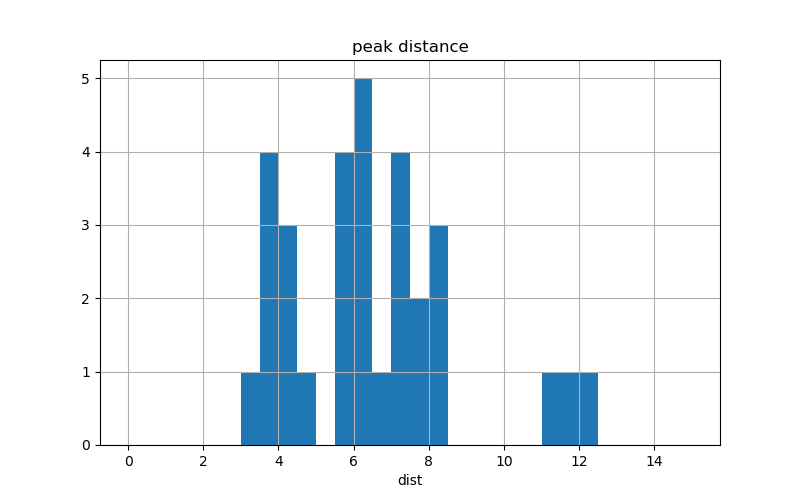

In [9]:
n_bins_x = 30
bin_edges_x = np.linspace(0, 15, n_bins_x + 1, endpoint=True)
bin_center_x = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])

# peaks distance
i = 0
j = 0
k = -1
plt.close('all')
fig, ax = plt.subplots(1, figsize=(8,5))
ax.hist(peaks_diff_array[i,j,k], bins=bin_edges_x)
ax.set_xlabel('dist')
ax.set_title(f'peak distance')
ax.grid()
plt.show()

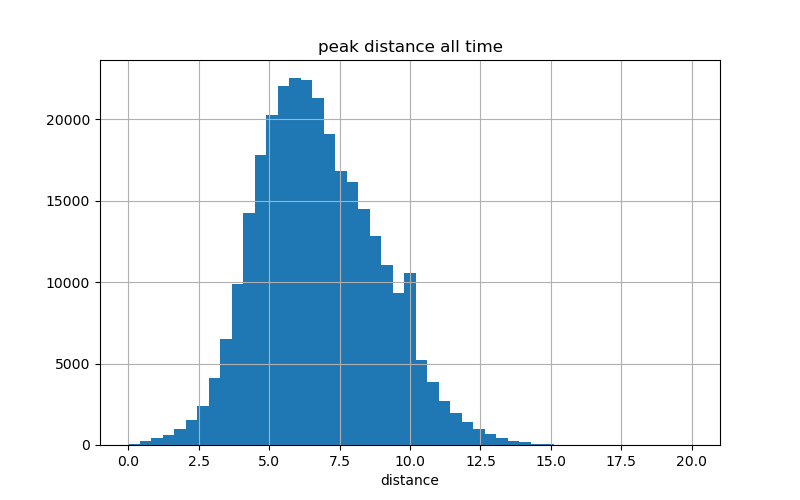

In [98]:
# peak distance time average hist
n_bins_x = 49
bin_edges_x = np.linspace(0, 20, n_bins_x + 1, endpoint=True)
bin_center_x = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])
peak_dist_hist = np.zeros(n_bins_x)

i = 0
j = 0

l = 0
for k in range(h5file.nt):
    peak_dist_hist += np.histogram(peaks_diff_array[i,j,k], bins=bin_edges_x)[0]
    l += len(peaks_diff_array[i,j,k])
plt.close('all')
fig, ax = plt.subplots(1, figsize=(8,5))
ax.bar(bin_center_x, peak_dist_hist, width=bin_edges_x[1]-bin_edges_x[0])
ax.set_xlabel('distance')
# ax.set_yscale('log')
ax.set_title(f'peak distance all time')
ax.grid()
plt.show()

In [168]:
# peak distance time average hist
n_bins_x = 51
bin_edges_x = np.linspace(0, 20, n_bins_x + 1, endpoint=True)
bin_center_x = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])
peak_dist_hist = np.zeros(n_bins_x)

i = 0
j = 0

l = 0
for k in range(h5file.nt):
    peak_dist_hist += np.histogram(peaks_diff_array[i,j,k], bins=bin_edges_x)[0]
    l += len(peaks_diff_array[i,j,k])
ax.bar(bin_center_x, peak_dist_hist/l/(bin_edges_x[1] - bin_edges_x[0]), width=bin_edges_x[1]-bin_edges_x[0])


<BarContainer object of 51 artists>

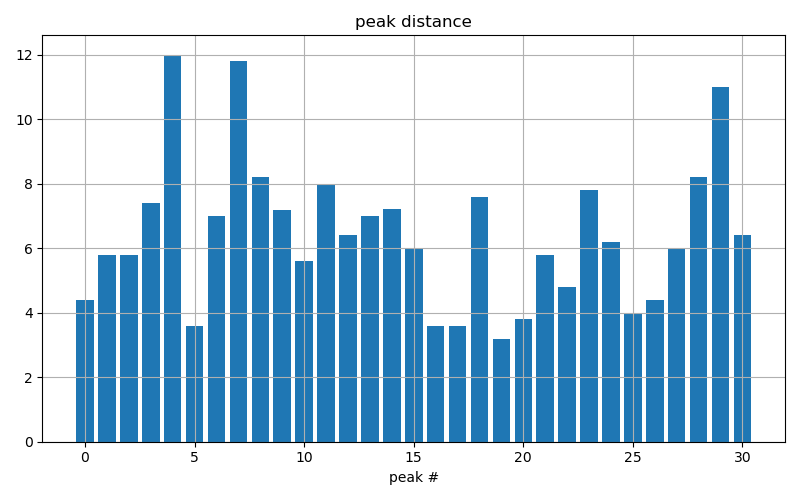

In [10]:
# peaks distance
i = 0
j = 0
k = -1
plt.close('all')
fig, ax = plt.subplots(1, figsize=(8,5))
ax.bar(np.arange(n_peaks_array[i,j,k]), peaks_diff_array[i,j,k])
ax.set_xlabel('peak #')
ax.set_title(f'peak distance')
ax.grid()
plt.tight_layout()
plt.show()

## L range study

In [182]:
# h5 to np array
# --------------
def n_peaks(u):
    # compute both find_peaks and find_half_peaks and compare
    n_peaks_bulk = len(np.array(h5file.x_range[find_peaks(u, height = 0.1)[0]]))
    n_peaks_edge = len(np.array(h5file.x_range[find_half_peaks(u, height = 0.1)]))
    return n_peaks_bulk + (n_peaks_edge - n_peaks_bulk)/2.

arr = np.empty(21, dtype=object)
L_array = 10**np.arange(-1, 1.1, step=0.1)
for q in range(21):
    filename = 'logistic_t_1e5_L_sweep_' + str(1+q) + '.h5'
    # ini file
    h5file = Comsol_data_analysis(filename, path_to_h5_files)
    pde_sol = h5file.analyse((lambda u: u), outsize=int(h5file.nx))
    peaks_array = h5file.analyse((lambda u: h5file.x_range[find_half_peaks(u, prominence=10)]), outtype=list)
    n_peaks_array = h5file.analyse(n_peaks)

    arr[q] = [h5file.x_range, pde_sol, peaks_array, n_peaks_array]


/tmp/ipykernel_102379/4033087886.py:104: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.x_range = np.array(self.file['positions/X'])
/tmp/ipykernel_102379/4033087886.py:131: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return np.array(self.file[self._index2path(indicies)])


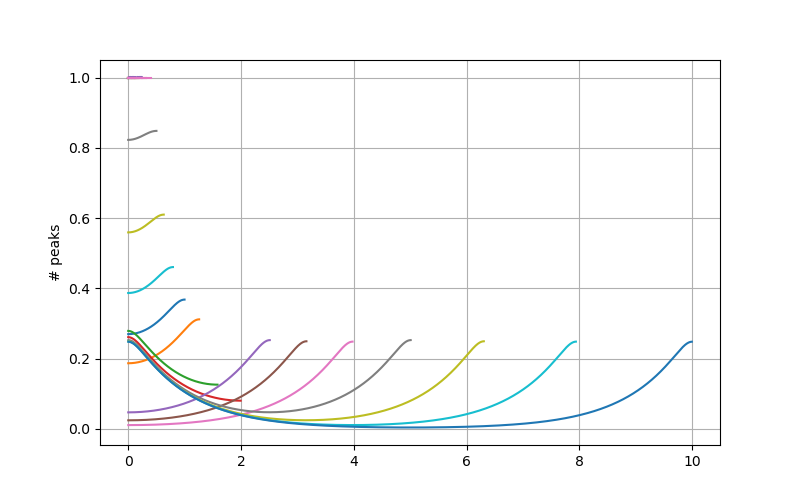

In [194]:
fig, ax = plt.subplots(1, figsize=(8,5))
for q in range(21):
    x_range, pde_sol, peaks_array, n_peaks_array = arr[q]
    ax.plot(x_range, pde_sol[0,0,-1])
ax.set_ylabel('# peaks')
ax.grid()
plt.show()

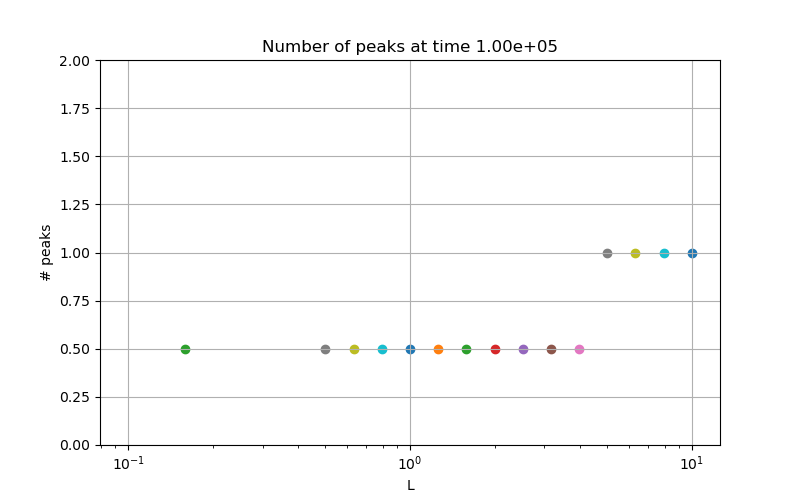

In [196]:
# number of peaks @ many L
i = 0
j = 0
k = -1
fig, ax = plt.subplots(1, figsize=(8,5))
for q in range(21):
    x_range, pde_sol, peaks_array, n_peaks_array = arr[q]
    ax.scatter(L_array[q], n_peaks_array[i,j,k])
ax.set_title(f'Number of peaks at time {h5file.t_range[k]:.2e}')
ax.set_xlabel('L')
ax.set_xscale('log')
ax.set_ylabel('# peaks')
ax.set_ylim(0,2)
ax.grid()
plt.show()

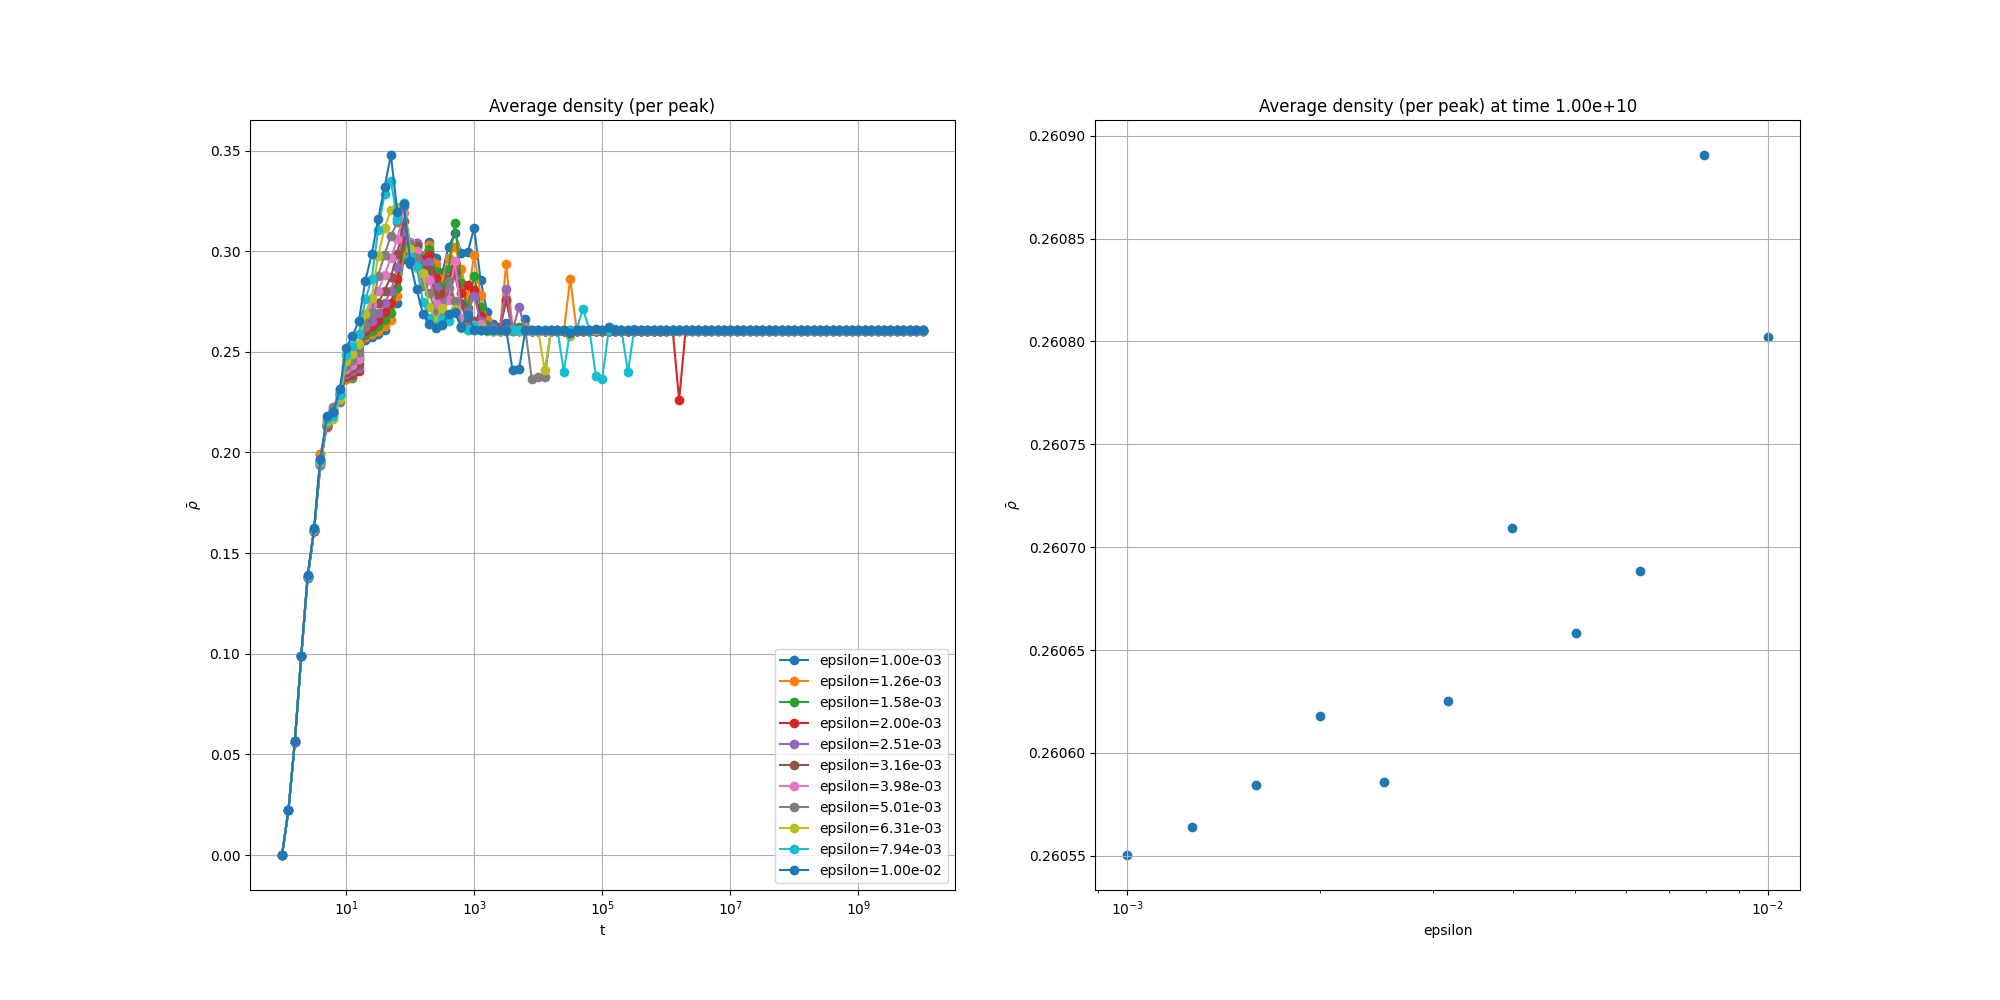

In [14]:
# number of peaks in time @ many epsilon
i = 0
k = -1
fig, axs = plt.subplots(1,2, figsize=(20,10))
ax = axs[0]
rho = np.sum(pde_sol, axis=-1) / h5file.xmax
# per peak normalization
rho /= n_peaks_array
for j in range(h5file.shape[1]):
    ax.plot(h5file.t_range, rho[i,j], '-o', label=f'epsilon={h5file.variables[1]["epsilon"][j]:.2e}')
ax.set_xlabel('t')
ax.set_title(f'Average density (per peak)')
ax.legend()
ax = axs[1]
ax.scatter(h5file.variables[1]["epsilon"], rho[i,:,k])
ax.set_title(f'Average density (per peak) at time {h5file.t_range[k]:.2e}')
ax.set_xlabel('epsilon')
for ax in axs:
    ax.set_xscale('log')
    ax.set_ylabel('$\\bar \\rho$')
    ax.grid()
plt.show()

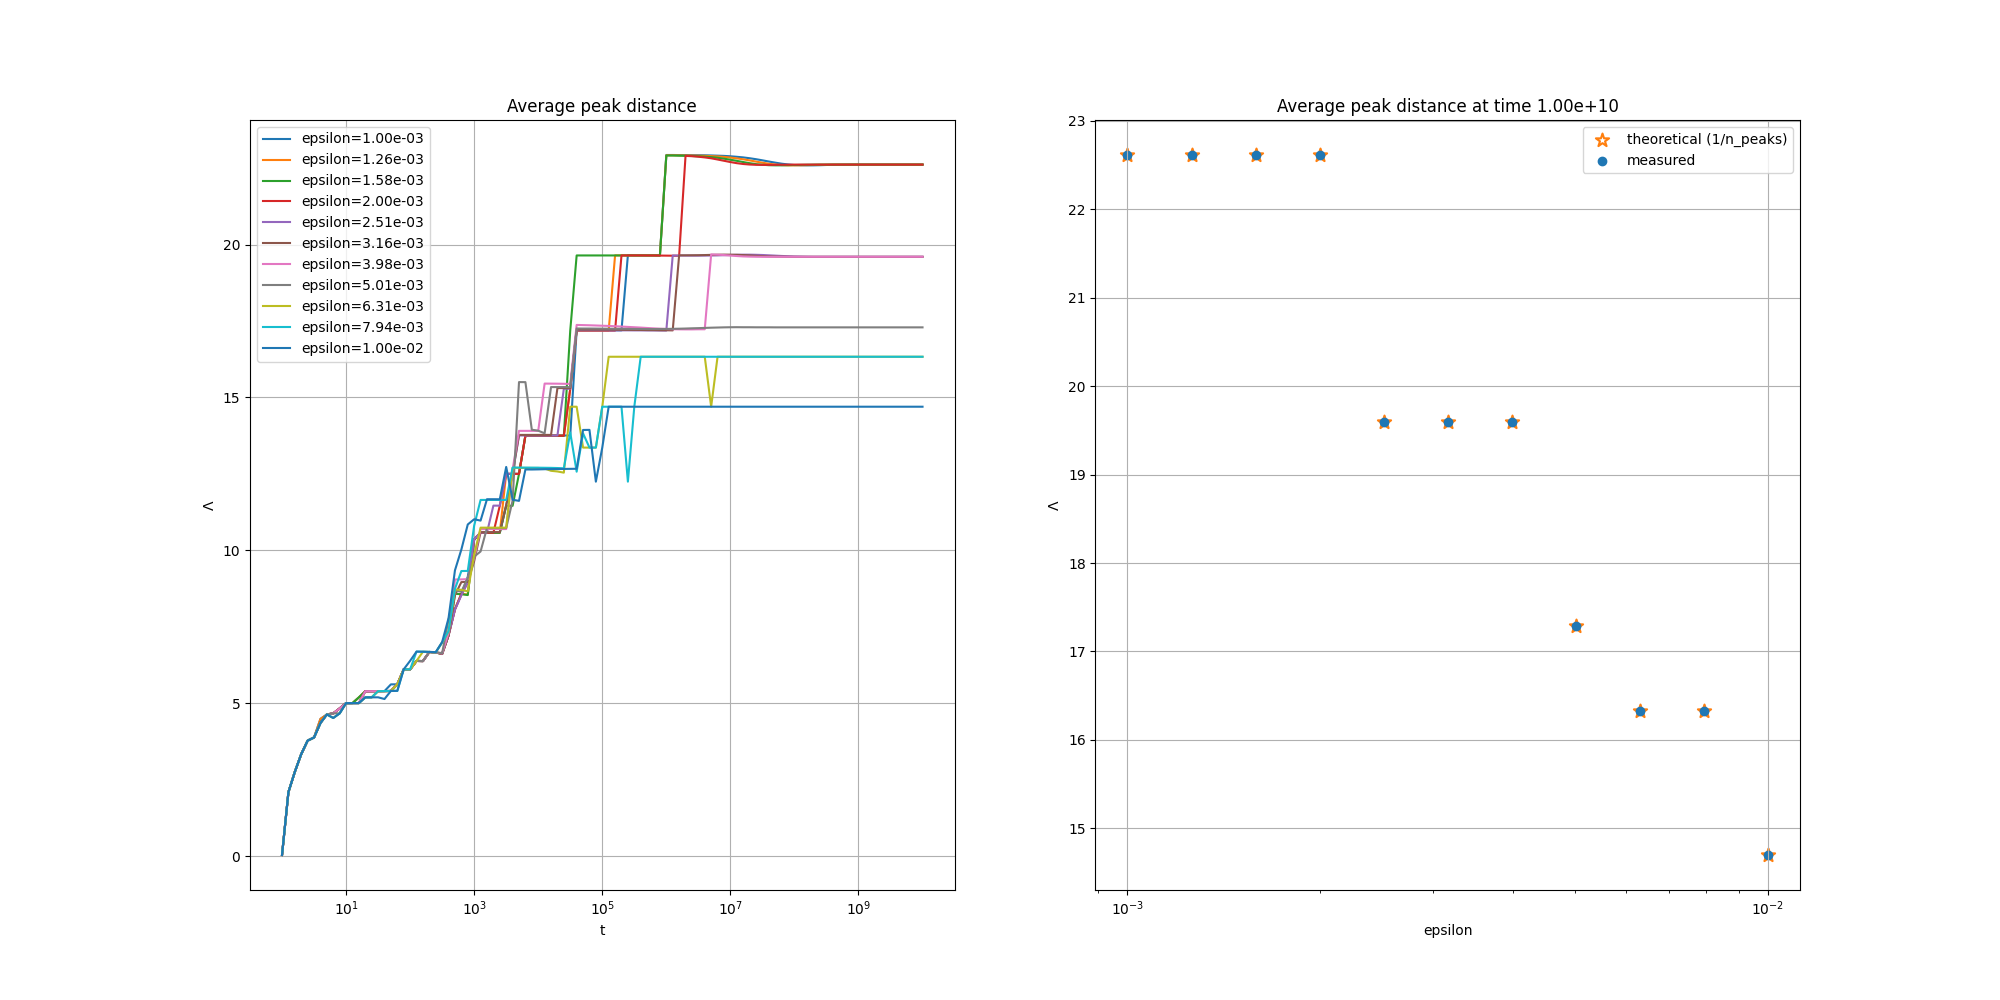

In [32]:
# peaks distance in time @ many epsilon
i = 0
k = -1
fig, axs = plt.subplots(1,2, figsize=(20,10))
ax = axs[0]
for j in range(h5file.shape[1]):
    ax.plot(h5file.t_range, [np.mean(peaks) for peaks in peaks_diff_array[i,j]], label=f'epsilon={h5file.variables[1]["epsilon"][j]:.2e}')
ax.set_xlabel('t')
ax.set_title(f'Average peak distance')
ax = axs[1]
ax.scatter(h5file.variables[1]["epsilon"], h5file.xmax/n_peaks_array[i,:,k], marker='*', s=100, edgecolors='tab:orange', linewidths=1.5, color=(0,0,0,0), label='theoretical (1/n_peaks)')
ax.scatter(h5file.variables[1]["epsilon"], [np.mean(peaks) for peaks in peaks_diff_array[i,:,k]], label='measured')
ax.set_title(f'Average peak distance at time {h5file.t_range[k]:.2e}')
ax.set_xlabel('epsilon')
for ax in axs:
    ax.set_xscale('log')
    ax.set_ylabel('$\\Lambda$')
    ax.legend()
    ax.grid()
plt.show()

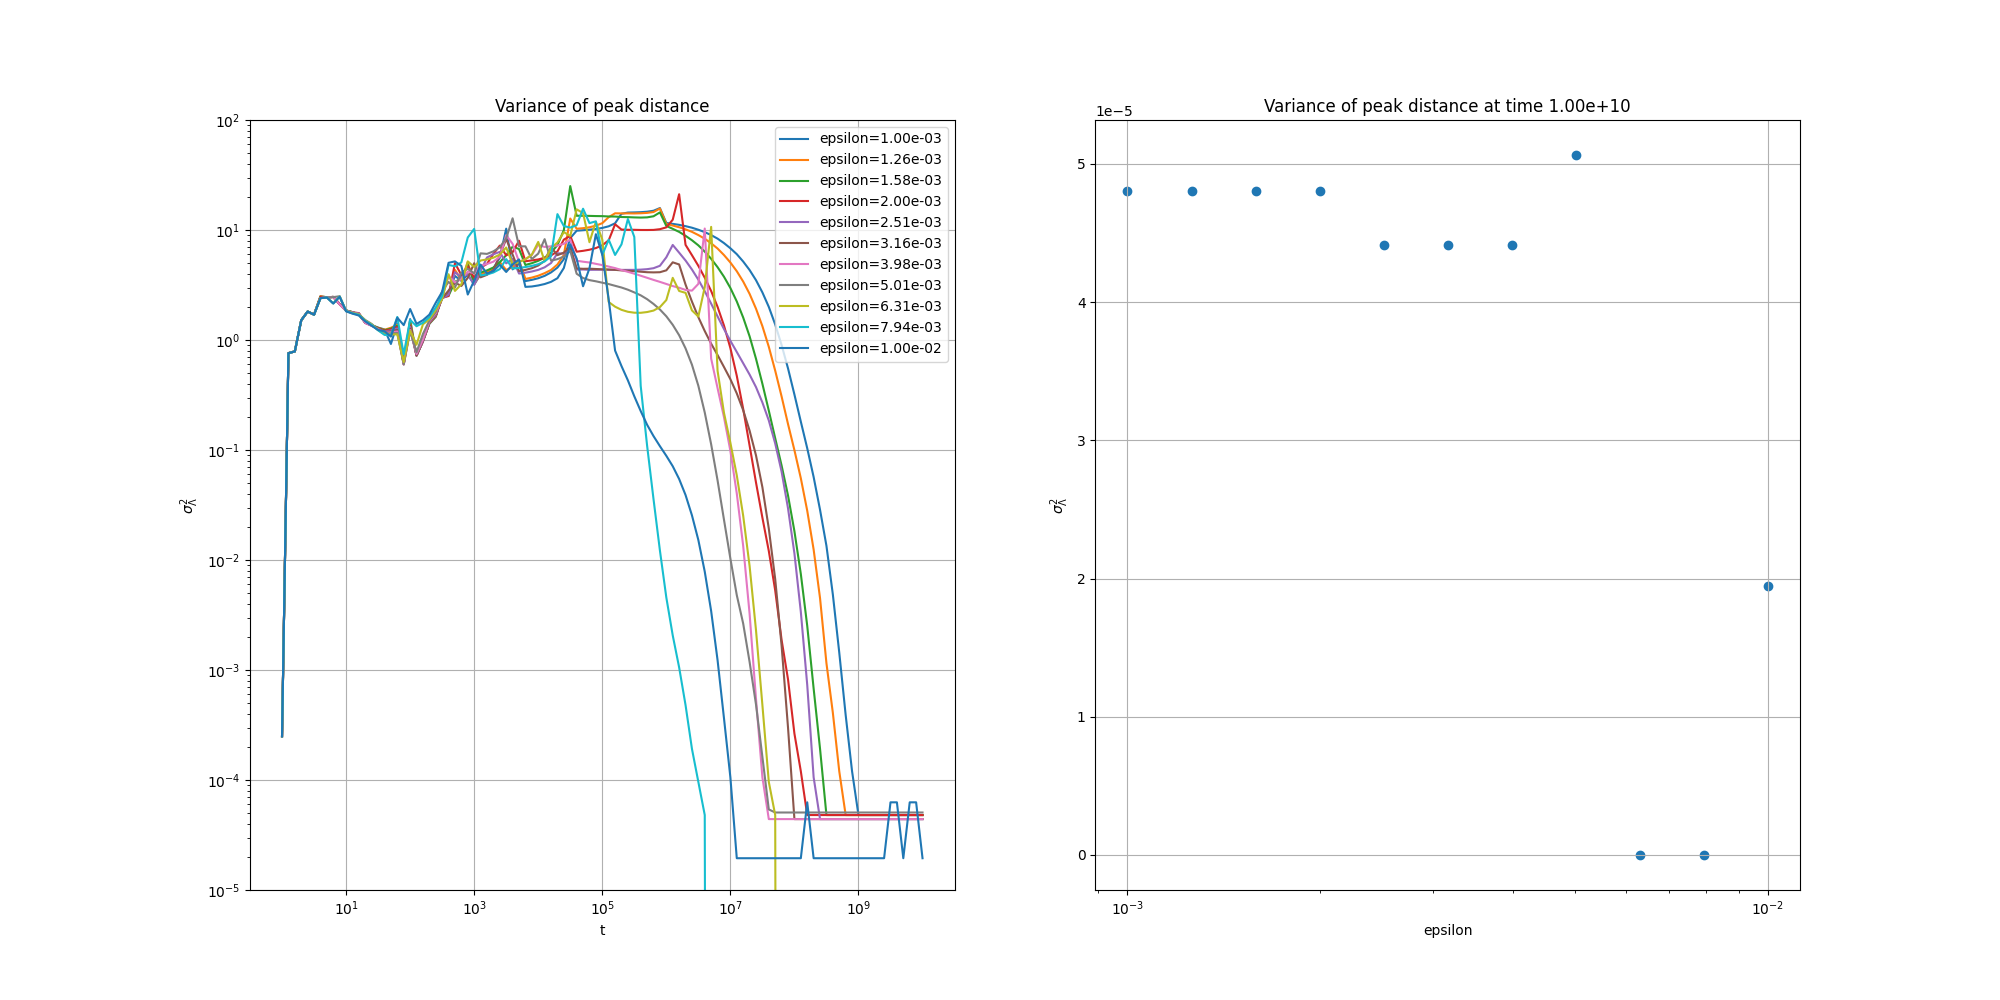

In [33]:
# peaks distance variance in time @ many epsilon
i = 0
k = -1
fig, axs = plt.subplots(1,2, figsize=(20,10))
ax = axs[0]
for j in range(h5file.shape[1]):
    ax.plot(h5file.t_range, [np.var(peaks) for peaks in peaks_diff_array[i,j]], label=f'epsilon={h5file.variables[1]["epsilon"][j]:.2e}')
ax.set_yscale('log')
ax.set_ylim(1e-5,1e2)
ax.set_xlabel('t')
ax.set_title(f'Variance of peak distance')
ax.legend()
ax = axs[1]
ax.scatter(h5file.variables[1]["epsilon"], [np.var(peaks) for peaks in peaks_diff_array[i,:,k]])
ax.set_title(f'Variance of peak distance at time {h5file.t_range[k]:.2e}')
ax.set_xlabel('epsilon')
for ax in axs:
    ax.set_xscale('log')
    ax.set_ylabel('$\\sigma_\\Lambda^2$')
    ax.grid()
plt.show()

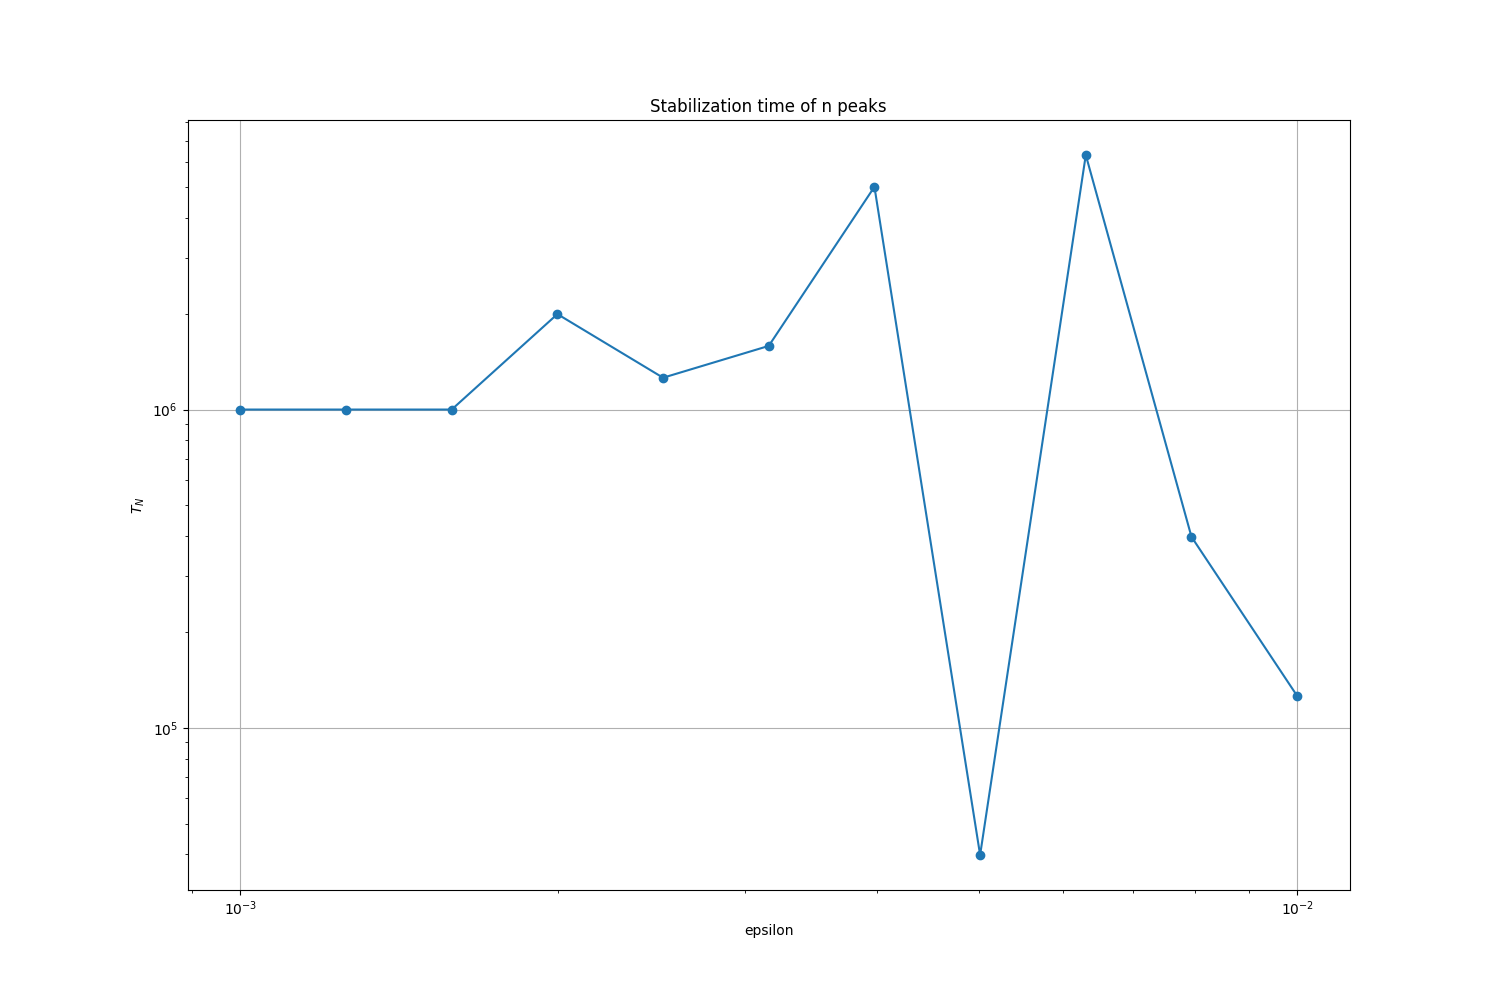

In [34]:
# n peaks stabilization time
i = 0
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(h5file.variables[1]["epsilon"], [h5file.t_range[np.where(np.gradient(n_peaks_array[i,j,:]) != 0.)][-1] for j in range(h5file.shape[1])], '-o')
ax.set_title(f'Stabilization time of n peaks')
ax.set_xlabel('epsilon')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$T_N$')
ax.grid()
plt.show()

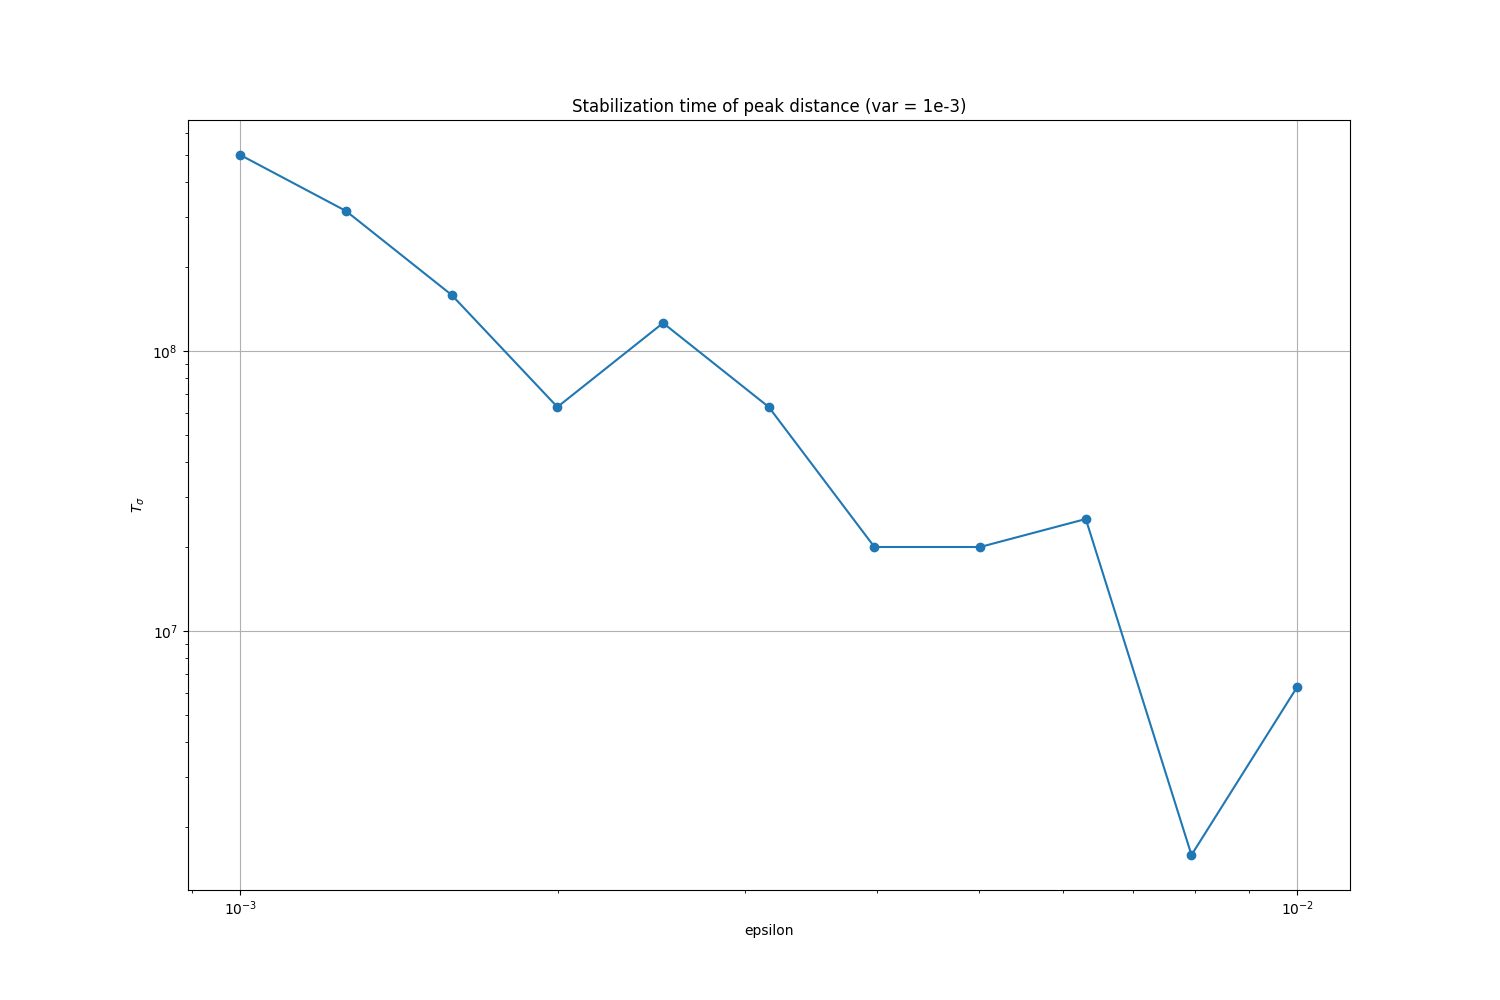

In [35]:
# n peaks stabilization time
i = 0
fig, ax = plt.subplots(1, figsize=(15,10))
ax.plot(h5file.variables[1]["epsilon"], [h5file.t_range[np.where(np.array([np.var(peaks) for peaks in peaks_diff_array[i,j]]) > 1e-3)][-1] for j in range(h5file.shape[1])], '-o')
ax.set_title(f'Stabilization time of peak distance (var = 1e-3)')
ax.set_xlabel('epsilon')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$T_\\sigma$')
ax.grid()
plt.show()

## Merge times from stepsize

In [30]:
import re
import numpy as np
a = []
with open("/scratch/n/Natan.Dominko/comsol_cluster/logistic_peak_stat/job.log", 'r') as f:
    for i,line in enumerate(f):
        valid = re.compile(r"[0-9]")
        if re.match(valid, line[0]):
            a.append(float(line.split()[2]))
            # print()
        if i > 10000000:
            break
a = np.array(a)
print(len(a))

2777409


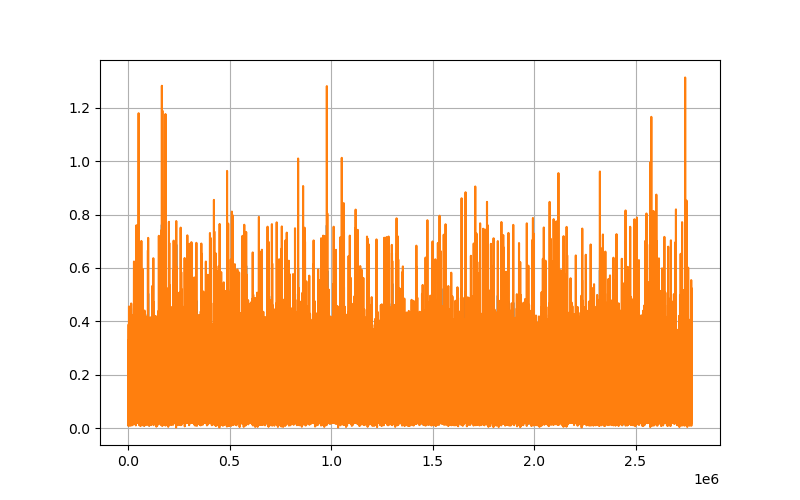

In [40]:
plt.close('all')
fig, ax = plt.subplots(1, figsize=(8,5))
ax.plot(np.convolve(a, np.ones(50)/50., 'same'))
ax.plot(a)
ax.grid()
plt.show()

In [44]:
from scipy.signal import find_peaks
for k in [1, 5, 10, 50, 100, 500]:
    print(len(find_peaks(np.convolve(a, np.ones(k)/k, 'same'))[0]))

21620
20755
19376
19328
18925
19989


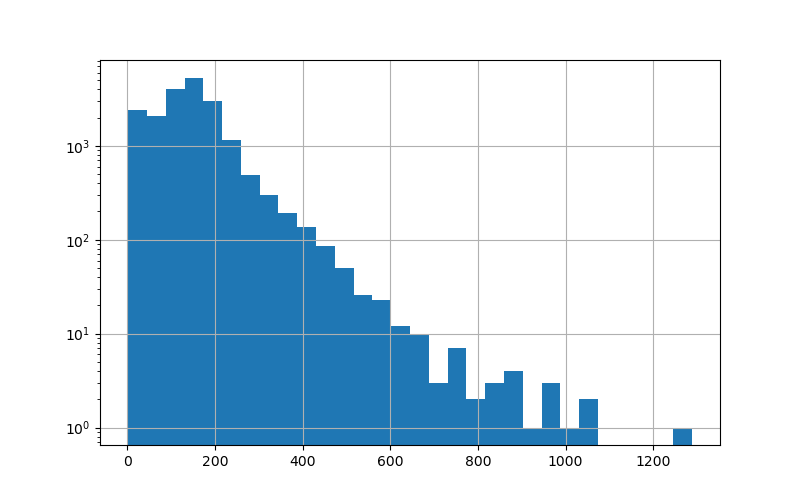

In [46]:
k = 50
b = find_peaks(np.convolve(a, np.ones(k)/k, 'same'))[0]
fig, ax = plt.subplots(1, figsize=(8,5))
ax.hist((b[1:]-b[:-1]), 30)
ax.grid()
ax.set_yscale('log')
plt.show()

## Rest

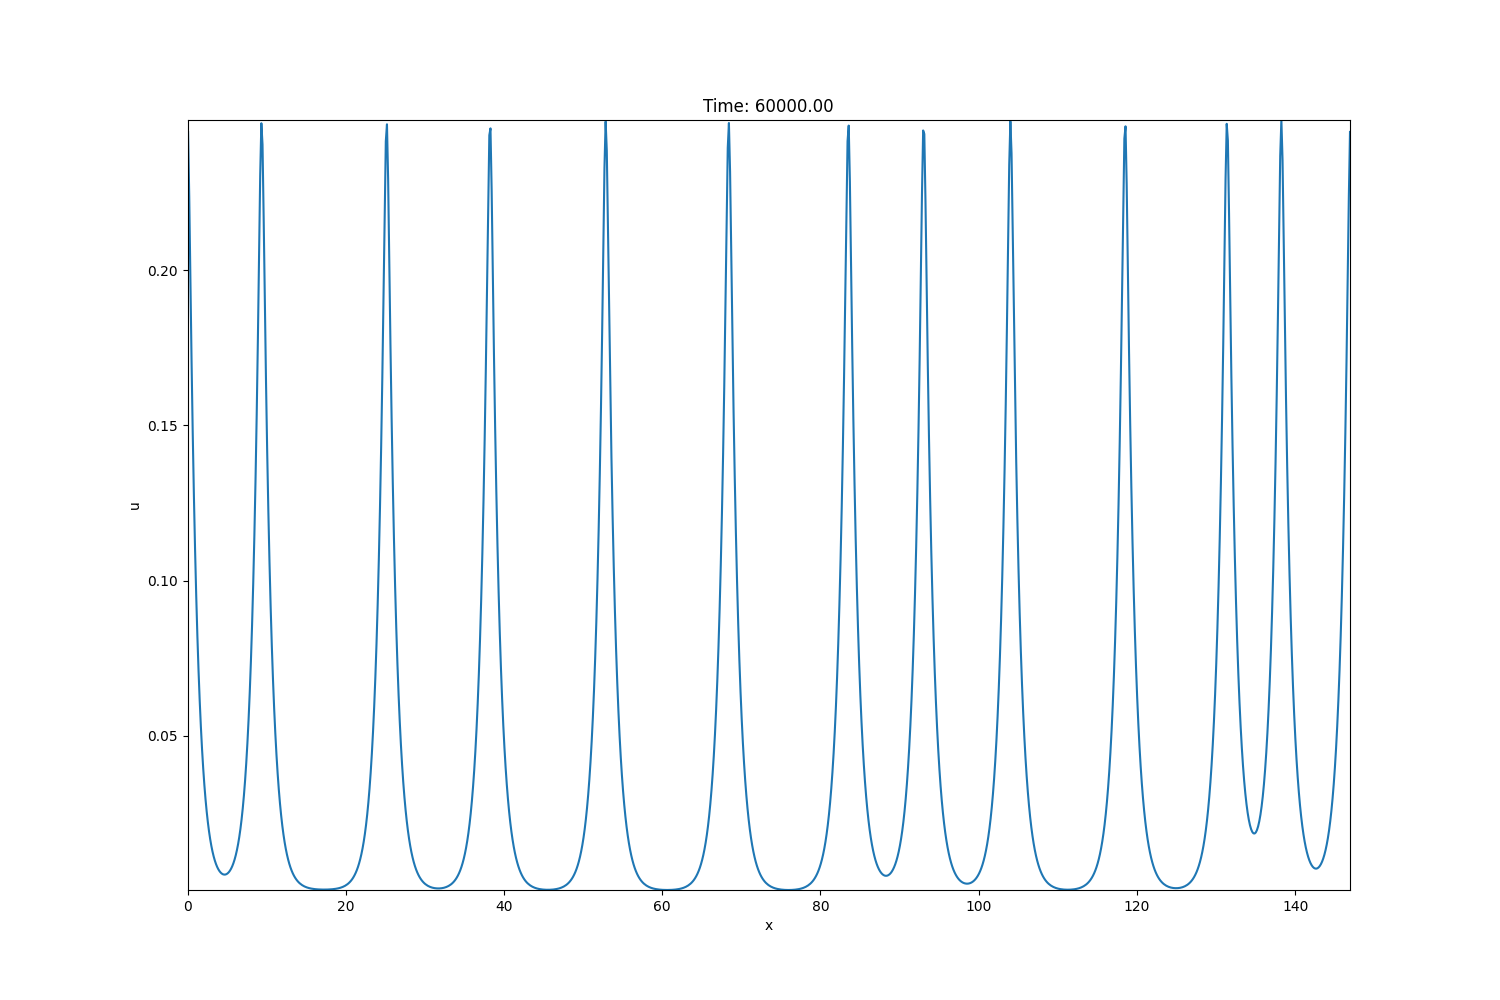

In [59]:

pde_sol_rho = pde_sol[0,0,:,:]

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Animation function
def animate(i):
    plt.cla()
    plt.plot(h5file.x_range, pde_sol_rho[i,:])
    plt.title(f'Time: {h5file.t_range[i]:.2f}')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.xlim(0.0, h5file.xmax)
    plt.ylim(np.min(pde_sol_rho[-1,:]), np.max(pde_sol_rho[-1,:]))

# Create animation
fig = plt.figure(figsize=(15,10))
ani = FuncAnimation(fig, animate, frames=h5file.nt, interval=50)
ani.save('animation.gif', writer='imagemagick', fps=10)# Display animation
# plt.show()


## Trash

In [ ]:
# old way to solve for P
from scipy.integrate import quad, simpson, cumulative_trapezoid
xs = 7.5
a = 1.92/2
k = 0.12
xmax = 29
N = 1
eps = 0.1
x0 = xs/2 + 1.2777#0.9094
V = np.exp(k*x0)*10

def v(x):
    return V*(1 - np.exp(-k*(x-x0)))*(1 - x/(xmax+1e-8))**3

def alpha(x):
    return np.maximum(0, a*(x-xs))

# x_array1 = np.linspace(0, xs/2, 100)
x_array2 = np.linspace(xmax/2, xmax, 10000)
x_array3 = np.linspace(xs, xmax/2, 10000)
x_array4 = np.linspace(xs/2, xs, 10000)
x_array5 = np.linspace(0, xs/2, 10000)

x_array23= np.linspace(xs, xmax, 10000)
av_int = cumulative_trapezoid(alpha(x_array23)/v(x_array23), x=x_array23, initial=0)
p_hom_23 = np.exp(-0.5*av_int)
from scipy.interpolate import Akima1DInterpolator
p_hom_interp = Akima1DInterpolator(x_array23, p_hom_23)

vP_2 = N*p_hom_interp(x_array2)
P_2 = vP_2 / v(x_array2)
    
P_2_interp = Akima1DInterpolator(x_array2, P_2)

def hihi(eps):
    particular_3 = 2*p_hom_interp(2*x_array3)/p_hom_interp(x_array3) * alpha(2*x_array3)/v(x_array3) + 0.5 * eps**2 * np.gradient(np.gradient(P_2_interp(2*x_array3), 2*x_array3), 2*x_array3)
    vP_3 = N*p_hom_interp(x_array3) * (
        1
        - simpson(particular_3, x=x_array3)
        + cumulative_trapezoid(particular_3, x=x_array3, initial=0)
    )
    P_3 = vP_3 / v(x_array3)
    
    P_23_interp = Akima1DInterpolator(np.hstack((x_array3, x_array2[1:])), np.hstack((P_3, P_2[1:])))
    
    # diverging
    vP_4 = vP_3[0] \
        - simpson(2*alpha(2*x_array4)*P_23_interp(2*x_array4), x=x_array4) \
        + cumulative_trapezoid(2*alpha(2*x_array4)*P_23_interp(2*x_array4), x=x_array4, initial=0)
    P_4 = vP_4 / v(x_array4)
    
    # not continuous
    # x_temp = np.linspace(xs/2, x0,10000)
    # vP_4 = cumulative_trapezoid(alpha(2*x_array4)*P_23_interp(2*x_array4) + 0.5 * eps**2 * np.gradient(np.gradient(P_23_interp(2*x_array4), 2*x_array4), 2*x_array4), x=x_array4, initial=0) #- simpson(alpha(2*x_temp)*P_23_interp(2*x_temp) + 0.5 * eps**2 * np.gradient(np.gradient(P_23_interp(2*x_temp), 2*x_temp), 2*x_temp), x=x_temp)
    # P_4 = vP_4 / v(x_array4)
    
    P_5 = P_4[0] * v(xs/2) / v(x_array5)

    return P_3, P_4, P_5

P_3, P_4, P_5 = hihi(0)
P_3_eps, P_4_eps, P_5_eps = hihi(eps)

fig, ax = plt.subplots(1, figsize=(8,5))
ax.plot(x_array2, P_2, 'k--', label='P2')
ax.plot(x_array3, P_3, 'k--', label='P3')
ax.plot(x_array4, P_4, 'k--', label='P4')
ax.plot(x_array5, P_5, 'k--', label='P5')

ax.plot(x_array3, P_3_eps, 'r', label='P3 eps')
ax.plot(x_array4, P_4_eps, 'r', label='P4 eps')
ax.plot(x_array5, P_5_eps, 'r', label='P5 eps')

ax.set_xlim(0,2*xs)
ax.vlines([xs/2, x0, xs, xmax/2, xmax], 0, np.max(P_3), ['k','r','k', 'b', 'b'])
ax.legend()
# ax.set_yscale('log')
ax.grid()
plt.show()

In [ ]:
# modified convolve for nonsymmetric kernel
def convolve_modified(array, eps_convolve, dx):
    if eps_convolve == 0.0: 
        return array
#     elif True: # gauss kernel
#         kernel = 1 / np.sqrt(2*np.pi) / eps * np.exp(-0.5 * (x / eps)**2)
#         return np.convolve(array, conv_kernel_array, mode='same') * dx
    elif True: # delay trick
        delay = int(eps_convolve/dx)
        array_padded_left = np.pad(array, (delay, 0))
        array_padded_right= np.pad(array, (0, delay))
        return 0.5 * (array_padded_left + array_padded_right)[delay//2: -delay//2]
    


In [ ]:
# finite element approach

# P(x) = sum_i sum_k c_ik phi_ik(x)
# integral ( PDE(P) * psi_j(x) ) = 0
# sum_ik c_ik integral ( PDE(phi_ik(x)) * phi_j(x) ) = 0
# A c = 0 => c

# phi_ik(x) = phi_k((x - x_i)/(x_i+1 - x_i))
# phi_ik(x) = phi_k((x - x_i)/h)  for fixed grid spacing h 
# PDE(phi_ik(x)) = -(v(x) * phi_ik(x))' + 2 a(2x) phi_ik(2x) - 1/2 a(x) phi_ik(x) 
# integral (phi_ik(2x) phi_jl(x)) !=0 at  i,k 2i,l and i,k 2i+1,l


In [48]:
def sample_sol(n_elements, n_functions, resolution, sol, intervals):
    x_array = np.zeros((n_elements * resolution))
    sol_sampl = np.zeros_like(x_array)
    
    for i in range(n_elements):
        # set correct x_array
        x_left, x_right = intervals[i], intervals[i+1]
        x_array_current = np.linspace(x_left, x_right, resolution, endpoint=False)
        x_array[i * resolution: (i + 1) * resolution] = x_array_current

       # (2 * x_array_current - x_right - x_left) / (x_right - x_left)
        
        for k in range(n_functions):
            # if i == n_elements-1 and k== n_functions-1:
            #     continue
            sol_sampl[i * resolution: (i + 1) * resolution] += sol[i * (n_functions - 1) + k] * basis[k](np.linspace(-1, 1, resolution, endpoint=False))
    return x_array, sol_sampl


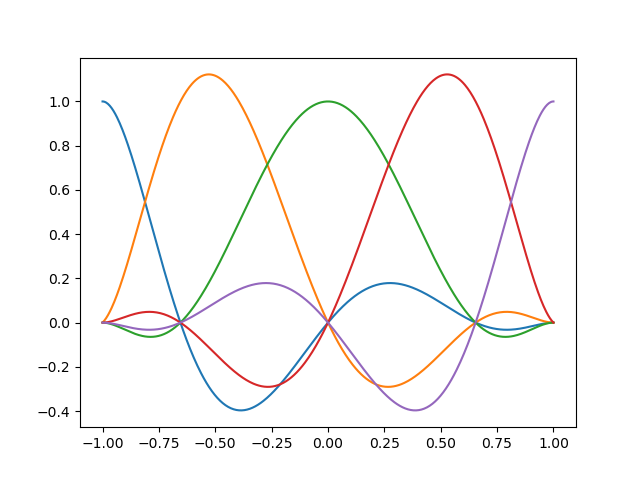

In [108]:
from numpy.polynomial.legendre import leggauss, legval, legder

def gauss_lobatto(n):
    # n is the number of points
    if n < 2:
        raise ValueError("Number of points must be at least 2")

    # The end points -1 and 1 are always included
    points = np.zeros(n)
    weights = np.zeros(n)

    # The first and last points are -1 and 1
    points[0] = -1
    points[-1] = 1

    # Calculate the inner points (roots of the derivative of Legendre polynomial of degree n-1)
    if n > 2:
        # Legendre polynomial of degree n-1
        Pn_1 = np.polynomial.legendre.Legendre.basis(n-1)
        Pn_1_der = Pn_1.deriv()

        # Get the roots of the derivative of the Legendre polynomial of degree n-1
        points[1:-1] = Pn_1_der.roots()

    # Calculate the weights
    weights[0] = 2 / (n * (n - 1))
    weights[-1] = weights[0]

    if n > 2:
        for i in range(1, n-1):
            xi = points[i]
            Pn_1_val = legval(xi, Pn_1.coef)
            weights[i] = 2 / (n * (n - 1) * (Pn_1_val ** 2))

    return points, weights


def gauss_lobatto_lagrange_basis(n_functions):
    
    points, weights = gauss_lobatto(n_functions)
    
    basis = np.empty(n_functions, dtype=object)
    for i in range(n_functions):
        delta = np.zeros(n_functions)
        delta[i] = 1.
        basis[i] = lagrange(points, delta)
        
    return basis

def gauss_lobatto_lagrange_basis(n_functions):
    
    points, weights = gauss_lobatto(n_functions)
    
    basis = np.empty(n_functions, dtype=object)
    for i in range(n_functions):
        delta = np.zeros(n_functions)
        delta[i] = 1.
        deriv_values = [None] * n_functions
        deriv_values[0] = deriv_values[-1] = 0.
        if i == 1:
            deriv_values[0] = 1. 
        elif i == n_functions-2:
            deriv_values[-1] = -1
        basis[i] = mixed_conditions_interpolation(points, delta, deriv_values)
    return basis

n_functions = 5
basis = gauss_lobatto_lagrange_basis(n_functions)
fig, ax = plt.subplots()

for i in range(n_functions):
    ax.plot(np.linspace(-1,1,500), basis[i](np.linspace(-1,1,500)))

Polynomial coefficients: [[ 1.  ]
 [ 1.  ]
 [-2.  ]
 [ 1.5 ]
 [-1.25]
 [ 0.  ]]


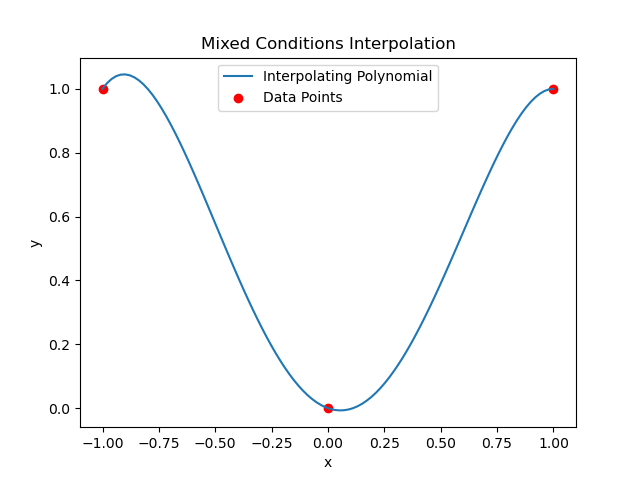

In [111]:
import numpy as np
from scipy.interpolate import KroghInterpolator

def mixed_conditions_interpolation(x_values, y_values, dy_values=None):
    """
    Construct a polynomial that satisfies mixed conditions:
    some fixed values and some fixed derivatives.
    
    Parameters:
    x_values (array): Points where conditions are specified.
    y_values (array): Function values at specified points.
    dy_values (array, optional): Derivative values at specified points.
                                 If None, only function values are considered.
                                 
    Returns:
    polynomial: A callable polynomial that satisfies the mixed conditions.
    """
    if dy_values is None:
        dy_values = [None] * len(x_values)
    
    x = []
    y = []
    
    for xi, yi, dyi in zip(x_values, y_values, dy_values):
        if dyi is None:
            x.append(xi)
            y.append(yi)
        else:
            x.extend([xi, xi])
            y.extend([yi, dyi])
    
    interpolator = KroghInterpolator(x, y)
    
    return interpolator

# Example usage:
x_values = [-1, 0, 1]
y_values = [1, 0, 1]
dy_values = [1, None, 0]  # None means no derivative constraint

# Get the interpolating polynomial
polynomial = mixed_conditions_interpolation(x_values, y_values, dy_values)

# Print the polynomial coefficients
print("Polynomial coefficients:", polynomial.c)

# Evaluate the polynomial at some points
x_test = np.linspace(-1, 1, 100)
y_test = polynomial(x_test)

# Plot the results
plt.close('all')
plt.plot(x_test, y_test, label='Interpolating Polynomial')
plt.scatter(x_values, y_values, color='red', label='Data Points')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Mixed Conditions Interpolation')
plt.show()


/tmp/ipykernel_282852/2224868239.py:69: RuntimeWarning: divide by zero encountered in log10
  ax.matshow(np.log10(np.abs(overlap_matrix)))


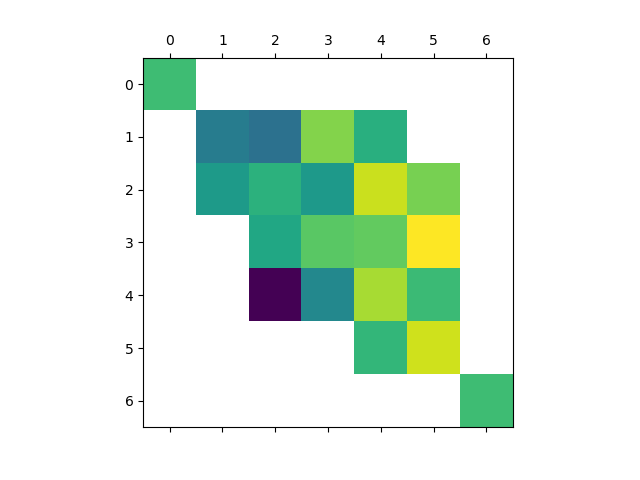

In [114]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

n_elements = 3
n_functions = 3
n_int_points = 5

overlap_matrix = np.zeros((n_elements * (n_functions - 1) + 1, n_elements * (n_functions - 1) + 1))
# points, weights = np.polynomial.legendre.leggauss(n_int_points)
points, weights = gauss_lobatto(n_int_points)
basis = gauss_lobatto_lagrange_basis(n_functions)

rate_args = (7.46, 0.07)
v_merge_args = (5., 0.19, 1.16, 0.005)

xmax = get_xinf((rate_args[0], *v_merge_args[1:]))
xmin = xmax/2**n_elements
intervals = xmin * 2**np.arange(0,n_elements+1)

def rate(x, args):
    xs, deriv = args
    return np.maximum(0, deriv * (x - xs))

def v_merge(x, args):
    x0, v_inf, k, perturb = args
    return v_inf * (1. - np.exp(-k*(x-x0))) - perturb * (x - x0)

def v_merge_der(x, args):
    x0, v_inf, k, perturb = args
    return k * v_inf * np.exp(-k*(x-x0)) - perturb

for i in range(n_elements):
    x_left = intervals[i]
    x_right = intervals[i+1]

    weights_transformed = weights * 0.5 * (x_right - x_left)
    points_transformed = points * 0.5 * (x_right - x_left) + 0.5 * (x_right + x_left)
    for k in range(n_functions):
        poly_k = basis[k]
    
        for l in range(n_functions):
            poly_l = basis[l]
            overlap_matrix[(n_functions - 1) * i + k, (n_functions - 1) * i + l] += np.sum(weights_transformed * 
                                                                              poly_k(points) *
                                                                              poly_l(points) *
                                                                              (-v_merge_der(points_transformed, v_merge_args) - 0.5 * rate(points_transformed, rate_args)))
            # poly_l_der = poly_l.derivative()
            overlap_matrix[(n_functions - 1) * i + k, (n_functions - 1) * i + l] += -np.sum(weights_transformed * 
                                                                              poly_k(points) *
                                                                              poly_l.derivative(points) *
                                                                              v_merge(points_transformed, v_merge_args))
            if i != n_elements-1:
                overlap_matrix[(n_functions - 1) * i + k, (n_functions - 1) * (i + 1) + l] += 2 * np.sum(weights_transformed * 
                                                                                      poly_k(points) *
                                                                                      poly_l(points) *
                                                                                      rate(2 * points_transformed, rate_args))

# BC
overlap_matrix[1:,0] = overlap_matrix[0,1:] = overlap_matrix[-1,:-1] = overlap_matrix[:-1,-1] = 0.
overlap_matrix[0,0] = overlap_matrix[-1,-1] = 1.
# for i in range(n_elements):
#     for k in range(n_functions):
#         if i == 0 and k == n_functions-2:
#             for l in range(n_functions):
#                 overlap_matrix[n_functions * i + k, n_functions * i + l] = (-1)**l

fig, ax = plt.subplots()
ax.matshow(np.log10(np.abs(overlap_matrix)))


[ 1.     0.     0.     0.    -0.    -0.     0.001]


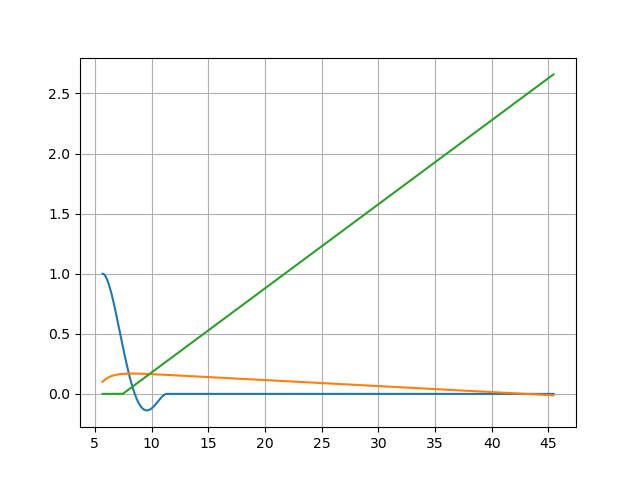

In [115]:
plt.close('all')
fig, ax = plt.subplots()
b = np.zeros(np.shape(overlap_matrix)[0])
b[0] = 1
b[-1] = 1e-3
# print(overlap_matrix[n_functions - 1, :])
# b[n_functions-2] = 1
# for i in range(n_elements):
#     b[i*n_functions-1] = 0
    
# overlap_matrix[np.abs(overlap_matrix) < 1e-10] = 0
sol = np.linalg.solve(overlap_matrix, b)
print(sol)
resolution = 1000
x, y = sample_sol(n_elements, n_functions, resolution, sol, intervals)
# from scipy.linalg import null_space
# ns = null_space(overlap_matrix, b)    
# print(ns)
ax.plot(x, y)
ax.plot(x,v_merge(x, v_merge_args))
ax.plot(x,rate(x, rate_args))
ax.grid()
# ax.set_yscale('log')
# ax.plot(np.linalg.eigvals(overlap_matrix).real)
# ax.plot(np.linalg.eigvals(overlap_matrix).real > 0, 'o')



In [120]:
vals, vects = np.linalg.eig(overlap_matrix)
vects[np.argsort(np.real(vals))[0]]
vects
# vects[np.argsort(np.real(vals))[1]]

array([[-9.79358219e-01, -1.91588606e-01,  7.41607757e-02,
        -3.71016625e-02,  2.85089651e-02],
       [-2.01654041e-01,  8.86622120e-01, -3.87930008e-01,
         2.01497371e-01, -1.21805067e-01],
       [-1.38851310e-02,  4.12691158e-01,  7.11785926e-01,
        -5.38369393e-01,  3.19441576e-01],
       [-5.74472393e-04,  8.23237752e-02,  5.55215082e-01,
         5.90290144e-01, -6.14983636e-01],
       [-1.69798457e-05,  1.01895752e-02,  1.70609191e-01,
         5.65453993e-01,  7.10002093e-01]])

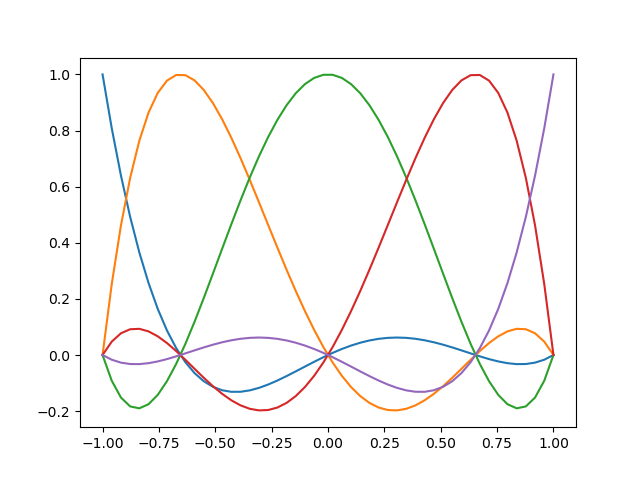

In [34]:
vals, vects = np.linalg.eig(overlap_matrix)
fig, ax = plt.subplots()

for i in range(n_functions):
    # pl = np.polynomial.legendre.Legendre(vects[np.argsort(np.real(vals))[i]])
    ax.plot(np.linspace(-1,1), basis[i](np.linspace(-1,1)))

In [59]:
import numpy as np
from numpy.polynomial.legendre import leggauss, Legendre

# Define the function to integrate (f(x) = 1)
def f(x):
    return 1

# Number of quadrature points
n = 5

# Get the Gauss-Legendre quadrature points and weights
points, weights = leggauss(n)

# Iterate over different degrees m of Legendre polynomials
for m in range(6):
    # Define the Legendre polynomial P_m(x)
    Pm = Legendre.basis(m)
    
    # Evaluate the Legendre polynomial at the quadrature points
    Pm_values = Pm(points)
    
    # Calculate the integral of P_m(x) * f(x)
    integral = np.sum(weights * Pm_values * f(points))
    
    print(f"Approximate integral of P_{m}(x) * f(x) over [-1, 1]: {integral}")


Approximate integral of P_0(x) * f(x) over [-1, 1]: 2.0
Approximate integral of P_1(x) * f(x) over [-1, 1]: 0.0
Approximate integral of P_2(x) * f(x) over [-1, 1]: 4.996003610813204e-16
Approximate integral of P_3(x) * f(x) over [-1, 1]: 0.0
Approximate integral of P_4(x) * f(x) over [-1, 1]: 1.3877787807814457e-16
Approximate integral of P_5(x) * f(x) over [-1, 1]: 0.0


In [214]:
import numpy as np
from scipy.integrate import quad, simpson, cumulative_trapezoid
from scipy.interpolate import Akima1DInterpolator
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

def interactive_plot(a=1.92, k=0.12, x0=4.5, V_factor=10):
    xs = 7.6
    xmax = 50
    V = np.exp(k * x0) * V_factor
    N = 1

    def v(x):
        return V * (1 - np.exp(-k * (x - x0))) * (1 - x / (xmax + 1e-8)) ** 3

    def alpha(x):
        return np.maximum(0, a * (x - xs))

    x_array2 = np.linspace(xmax / 2, xmax, 1000)
    x_array3 = np.linspace(xs, xmax / 2, 1000)
    x_array4 = np.linspace(xs / 2, xs, 1000)
    x_array5 = np.linspace(0, xs / 2, 1000)

    x_array23 = np.linspace(xs, xmax, 1000)
    av_int = cumulative_trapezoid(alpha(x_array23) / v(x_array23), x=x_array23, initial=0)
    p_hom_23 = np.exp(-0.5 * av_int)
    p_hom_interp = Akima1DInterpolator(x_array23, p_hom_23)

    vP_2 = N * p_hom_interp(x_array2)
    P_2 = vP_2 / v(x_array2)

    vP_3 = N * p_hom_interp(x_array3) * (
        1
        - simpson(p_hom_interp(2 * x_array3) / p_hom_interp(x_array3) * alpha(2 * x_array3) / v(x_array3), x=x_array3)
        + cumulative_trapezoid(p_hom_interp(2 * x_array3) / p_hom_interp(x_array3) * alpha(2 * x_array3) / v(x_array3), x=x_array3, initial=0)
    )
    P_3 = vP_3 / v(x_array3)

    P_23_interp = Akima1DInterpolator(np.hstack((x_array3, x_array2[1:])), np.hstack((P_3, P_2[1:])))

    vP_4 = vP_3[0] \
        - simpson(alpha(2 * x_array4) * P_23_interp(2 * x_array4), x=x_array4) \
        + cumulative_trapezoid(alpha(2 * x_array4) * P_23_interp(2 * x_array4), x=x_array4, initial=0)
    P_4 = vP_4 / v(x_array4)

    x_temp = np.linspace(xs / 2, x0, 1000)
    vP_4 = cumulative_trapezoid(alpha(2 * x_array4) * P_23_interp(2 * x_array4), x=x_array4, initial=0) - simpson((alpha(2 * x_temp) * P_23_interp(2 * x_temp)), x=x_temp)
    P_4 = vP_4 / v(x_array4)

    P_5 = P_4[0] * v(xs / 2) / v(x_array5)

    fig, ax = plt.subplots(1, figsize=(8, 5))
    ax.plot(x_array2, P_2, label='P2')
    ax.plot(x_array3, P_3, label='P3')
    ax.plot(x_array4, P_4, label='P4')
    ax.plot(x_array5, P_5, label='P5')

    ax.set_xlim(0, 2 * xs)
    ax.set_ylim(0, 1)
    ax.vlines([xs / 2, x0, xs, xmax / 2, xmax], 0, np.max(P_3), ['k', 'r', 'k', 'b', 'b'])
    ax.legend()
    ax.grid()
    plt.show()

interact(interactive_plot, 
         a=FloatSlider(min=0, max=10, step=0.1, value=1.92),
         k=FloatSlider(min=0, max=1, step=0.01, value=0.12),
         x0=FloatSlider(min=3.71, max=10, step=0.1, value=4.5),
         V_factor=FloatSlider(min=1, max=100, step=1, value=10))


interactive(children=(FloatSlider(value=1.92, description='a', max=10.0), FloatSlider(value=0.12, description=…

<function __main__.interactive_plot(a=1.92, k=0.12, x0=4.5, V_factor=10)>